# Importing

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
#Set Up
!pip install --upgrade --quiet scikit-learn imbalanced-learn
# Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MultiLabelBinarizer


# Feature Engineering
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest
from imblearn.over_sampling import SMOTE
# Models
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Utilities
from sklearn.compose import ColumnTransformer
from collections import Counter
from sklearn.pipeline import Pipeline
from tqdm.auto import tqdm
import joblib
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from scipy.stats import kendalltau
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 80.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


# Datasets

In [2]:
demos = pd.read_csv("/kaggle/input/datasets/raw/demos.csv")
dlcs = pd.read_csv("/kaggle/input/datasets/raw/dlcs.csv")
gamalyticMS1 = pd.read_csv("/kaggle/input/datasets/raw/gamalytic_steam_games.csv")
gamalyticMS2 = pd.read_csv("/kaggle/input/datasets/raw/ms2_gamalytic_steam_games.csv")
info = pd.read_csv("/kaggle/input/datasets/raw/info_base_games.csv", low_memory=False)

# Combining Datasets

In [3]:
def MergeDatasets(demos, dlcs, gamalytic, info , OutputFileName):
      demos.columns = demos.columns.str.strip()
      dlcs.columns = dlcs.columns.str.strip()
      gamalytic.columns = gamalytic.columns.str.strip()
      info.columns = info.columns.str.strip()

      demos.rename(columns={"full_game_appid": "Full_game_appid"}, inplace=True)
      dlcs.rename(columns={"base_appid": "Full_game_appid"}, inplace=True)
      gamalytic.rename(columns={"steamId": "Full_game_appid"}, inplace=True)
      info.rename(columns={"appid": "Full_game_appid"}, inplace=True)


      demos["Full_game_appid"] = demos["Full_game_appid"].astype(str)
      dlcs["Full_game_appid"] = dlcs["Full_game_appid"].astype(str)
      gamalytic["Full_game_appid"] = gamalytic["Full_game_appid"].astype(str)
      info["Full_game_appid"] = info["Full_game_appid"].astype(str)


      merged_df = demos.merge(dlcs, on="Full_game_appid", how="left") \
                  .merge(gamalytic, on="Full_game_appid", how="inner") \
                  .merge(info, on="Full_game_appid", how="left")
      merged_df.drop(columns=['Unnamed: 0','demo_appid','dlc_appid','Full_game_appid'], inplace=True)
      merged_df.to_csv(f"D:\\ML Milestone 1\\ML milestone 1\\data\\raw\\{OutputFileName}.csv", index=False)
      print(merged_df.columns)
      print("Demos:", demos.shape)
      print("DLCs:", dlcs.shape)
      print("Gamalytic:", gamalytic.shape)
      print("Merged shape:", merged_df.shape)

      if 'reviewScore' in merged_df.columns:
            review_score = merged_df.pop('reviewScore')
            merged_df['reviewScore'] = review_score
      return merged_df

# Regression Ms1

In [4]:
Regression_df = MergeDatasets(demos, dlcs, gamalyticMS1, info , "Regression_combined_games")
Regression_df.head()

Index(['name_x', 'name_y', 'price', 'copiesSold', 'publisherClass',
       'reviewScore', 'aiContent', 'name', 'metacritic', 'steam_achievements',
       'steam_trading_cards', 'workshop_support', 'genres',
       'achievements_total', 'release_date', 'supported_platforms'],
      dtype='object')
Demos: (15449, 4)
DLCs: (5445, 3)
Gamalytic: (93338, 6)
Merged shape: (9159, 16)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,name_x,name_y,price,copiesSold,publisherClass,aiContent,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms,reviewScore
0,Rolando Deluxe Demo,NaN,9.99,58,Hobbyist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
1,Outrunner: Neon Nights Demo,NaN,9.99,60,Hobbyist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
2,Bubble Ghost Remake Demo,NaN,19.99,253,Indie,NaN,Bubble Ghost Remake,NaN,True,False,False,"Action, Adventure, Indie",NaN,"Mar 26, 2025",['windows'],100
3,Time Handlers Demo,NaN,13.99,174,Hobbyist,NaN,Time Handlers,NaN,True,False,False,"Adventure, Indie",32,"Jan 11, 2024","['windows', 'mac', 'linux']",75
4,Musical Vibes Demo,NaN,11.99,8,Hobbyist,NaN,Musical Vibes,NaN,False,False,False,Casual,NaN,"Nov 1, 2023",['windows'],100


## Data Inspection

In [5]:
df = Regression_df
print("Combined shape:", df.shape)
df.info()

Combined shape: (9159, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9159 entries, 0 to 9158
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name_x               9158 non-null   object 
 1   name_y               649 non-null    object 
 2   price                9159 non-null   float64
 3   copiesSold           9159 non-null   int64  
 4   publisherClass       9159 non-null   object 
 5   aiContent            0 non-null      float64
 6   name                 7535 non-null   object 
 7   metacritic           483 non-null    object 
 8   steam_achievements   7535 non-null   object 
 9   steam_trading_cards  7535 non-null   object 
 10  workshop_support     7535 non-null   object 
 11  genres               7531 non-null   object 
 12  achievements_total   4792 non-null   object 
 13  release_date         7535 non-null   object 
 14  supported_platforms  7535 non-null   object 
 15  reviewScore

In [6]:
df.describe()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,price,copiesSold,aiContent,reviewScore
count,9159.000000,9.159000e+03,0.0,9159.000000
mean,10.145054,4.625278e+04,NaN,77.937875
std,9.803252,4.806317e+05,NaN,27.632133
min,0.000000,0.000000e+00,NaN,0.000000
25%,4.990000,4.600000e+01,NaN,71.000000
50%,7.990000,3.740000e+02,NaN,88.000000
75%,13.990000,3.583000e+03,NaN,98.000000
max,240.000000,2.624442e+07,NaN,100.000000


In [7]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,name_x,name_y,price,copiesSold,publisherClass,aiContent,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms,reviewScore
0,Rolando Deluxe Demo,NaN,9.99,58,Hobbyist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
1,Outrunner: Neon Nights Demo,NaN,9.99,60,Hobbyist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
2,Bubble Ghost Remake Demo,NaN,19.99,253,Indie,NaN,Bubble Ghost Remake,NaN,True,False,False,"Action, Adventure, Indie",NaN,"Mar 26, 2025",['windows'],100
3,Time Handlers Demo,NaN,13.99,174,Hobbyist,NaN,Time Handlers,NaN,True,False,False,"Adventure, Indie",32,"Jan 11, 2024","['windows', 'mac', 'linux']",75
4,Musical Vibes Demo,NaN,11.99,8,Hobbyist,NaN,Musical Vibes,NaN,False,False,False,Casual,NaN,"Nov 1, 2023",['windows'],100


In [8]:
df.tail()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,name_x,name_y,price,copiesSold,publisherClass,aiContent,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms,reviewScore
9154,Miryam: The Polluted Land DEMO,NaN,4.99,52,Hobbyist,NaN,Miryam: The Polluted Land,NaN,True,True,True,"Adventure, Casual, Indie, RPG, Strategy",NaN,"Mar 5, 2025","['windows', 'mac', 'linux']",100
9155,ORDER 13 Demo,NaN,8.99,30107,Indie,NaN,ORDER 13,NaN,False,False,False,"Action, Indie, Simulation",NaN,Mar-25,['windows'],87
9156,Fruitbus Demo,NaN,24.99,16344,Indie,NaN,Fruitbus,NaN,True,False,False,"Adventure, Casual, Indie, Simulation",30.0,"Oct 28, 2024",['windows'],87
9157,Drill to the Stars Demo,NaN,14.99,57,Hobbyist,NaN,Drill to the Stars,NaN,True,False,False,"Indie, Strategy",27.0,"Feb 7, 2025",['windows'],100
9158,Mechanic 8230: Escape from Ilgrot Demo,NaN,12.99,3150,Indie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90


In [9]:
df.isna().sum()

name_x                    1
name_y                 8510
price                     0
copiesSold                0
publisherClass            0
aiContent              9159
name                   1624
metacritic             8676
steam_achievements     1624
steam_trading_cards    1624
workshop_support       1624
genres                 1628
achievements_total     4367
release_date           1624
supported_platforms    1624
reviewScore               0
dtype: int64

In [10]:
df.isnull().sum()

name_x                    1
name_y                 8510
price                     0
copiesSold                0
publisherClass            0
aiContent              9159
name                   1624
metacritic             8676
steam_achievements     1624
steam_trading_cards    1624
workshop_support       1624
genres                 1628
achievements_total     4367
release_date           1624
supported_platforms    1624
reviewScore               0
dtype: int64

In [11]:
df.duplicated().sum()

0

In [12]:
print("\n=== Detailed Column Analysis ===")

print("\n1. Metacritic Analysis:")
print("Missing values:", df['metacritic'].isna().sum())
print("Percentage missing:", (df['metacritic'].isna().sum() / len(df)) * 100)

df['metacritic'] = pd.to_numeric(df['metacritic'], errors='coerce')
if 'reviewScore' in df.columns:
    df['reviewScore'] = pd.to_numeric(df['reviewScore'], errors='coerce')
    
    print("\nCorrelation with reviewScore:", df['metacritic'].corr(df['reviewScore']))

print("\nMetacritic statistics:")
print(df['metacritic'].describe())

print("\n2. Achievements Analysis:")

df['achievements_total'] = pd.to_numeric(df['achievements_total'], errors='coerce')

print("Missing values:", df['achievements_total'].isna().sum())
print("Percentage missing:", (df['achievements_total'].isna().sum() / len(df)) * 100)

print("\nGames with achievements:")
print(df[df['achievements_total'] > 0]['achievements_total'].describe())

if 'reviewScore' in df.columns:
    print("\nCorrelation with reviewScore:", df['achievements_total'].corr(df['reviewScore']))

print("\n3. Genres Analysis:")
print("Missing values:", df['genres'].isna().sum())
print("Percentage missing:", (df['genres'].isna().sum() / len(df)) * 100)
print("\nTop 10 most common genres:")
print(df['genres'].value_counts().head(10))

print("\n4. Release Date Analysis:")
print("Missing values:", df['release_date'].isna().sum())
print("Percentage missing:", (df['release_date'].isna().sum() / len(df)) * 100)
print("\nRelease date distribution:")
print(df['release_date'].value_counts().head())

print("\n5. High Missing Value Columns Analysis:")
columns_to_check = ['aiContent','name_x', 'name_y']
for col in columns_to_check:
    print(f"\n{col} missing values:", df[col].isna().sum())
    print(f"Percentage missing:", (df[col].isna().sum() / len(df)) * 100)

print("\n6. Duplicate Analysis:")
print("Number of duplicate rows:", df.duplicated().sum())
print("\nSample of duplicate rows:")
df[df.duplicated()].head()


=== Detailed Column Analysis ===

1. Metacritic Analysis:
Missing values: 8676
Percentage missing: 94.72649852603996

Correlation with reviewScore: 0.6158186623772345

Metacritic statistics:
count    483.000000
mean      74.391304
std        9.655373
min       32.000000
25%       70.000000
50%       76.000000
75%       81.000000
max       96.000000
Name: metacritic, dtype: float64

2. Achievements Analysis:
Missing values: 4367
Percentage missing: 47.67987771590785

Games with achievements:
count    4713.000000
mean       30.237853
std        46.333891
min         1.000000
25%        13.000000
50%        23.000000
75%        38.000000
max      2600.000000
Name: achievements_total, dtype: float64

Correlation with reviewScore: 0.047087995204873424

3. Genres Analysis:
Missing values: 1628
Percentage missing: 17.77486625177421

Top 10 most common genres:
genres
Action, Indie               480
Action, Adventure, Indie    441
Adventure, Indie            371
Casual, Indie               322

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,name_x,name_y,price,copiesSold,publisherClass,aiContent,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms,reviewScore


## EDA

### Univariate Analysis

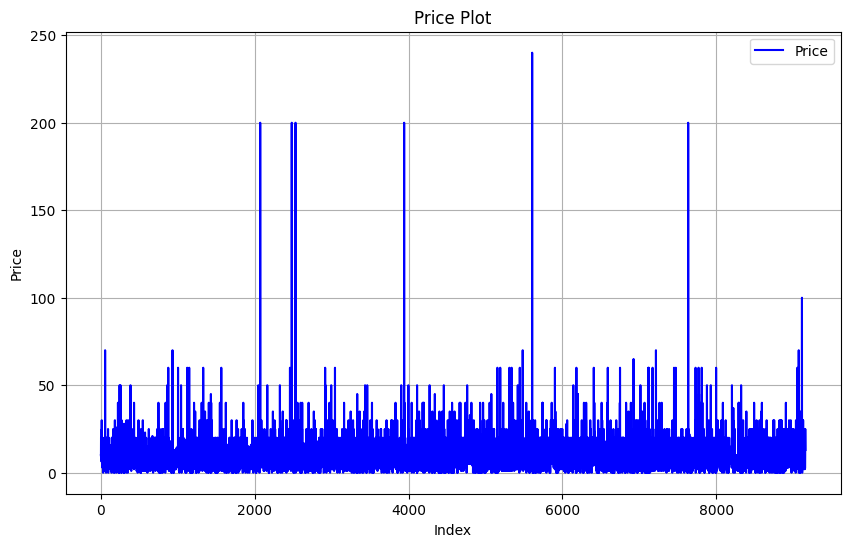

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(df['price'], label='Price', color='blue')
plt.title('Price Plot')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

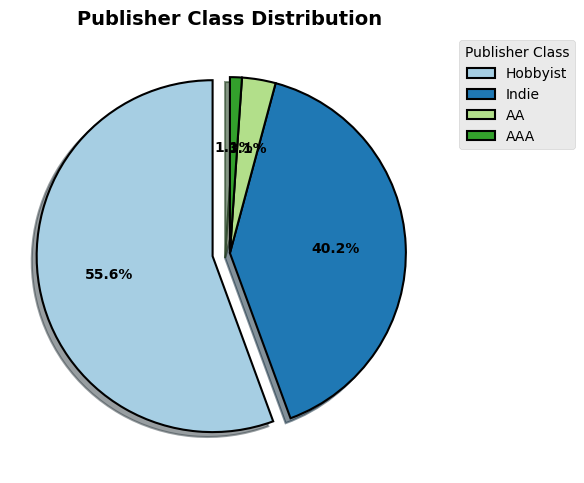

In [14]:
plt.style.use("ggplot")
publisher_class_counts = df['publisherClass'].value_counts()
explode = [0.1 if i == 0 else 0 for i in range(len(publisher_class_counts))]

plt.figure(figsize=(6, 6))
patches, texts, autotexts = plt.pie(
    publisher_class_counts,
    labels=None,  
    autopct='%1.1f%%', 
    startangle=90,
    textprops={"fontweight": "bold"},
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    colors=plt.cm.Paired.colors
)

plt.legend(patches, publisher_class_counts.index, loc='upper right', bbox_to_anchor=(1.3, 1), title="Publisher Class")
plt.title('Publisher Class Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [15]:
df['reviewScore'].value_counts()

reviewScore
100    2178
0       685
94      254
95      252
93      245
       ... 
16        1
5         1
7         1
18        1
11        1
Name: count, Length: 93, dtype: int64

In [16]:
df['price'].value_counts()

price
9.99     1327
4.99     1184
14.99     780
19.99     662
2.99      515
         ... 
14.80       1
6.98        1
7.11        1
12.00       1
99.99       1
Name: count, Length: 111, dtype: int64

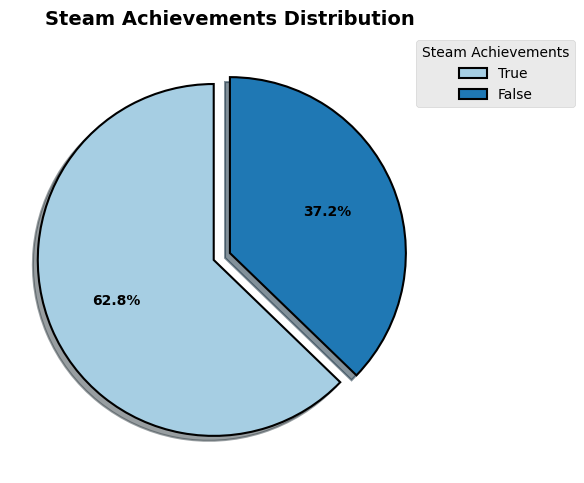

In [17]:
steam_achievements_counts = df['steam_achievements'].value_counts()
plt.style.use("ggplot")
explode = [0.1 if i == 0 else 0 for i in range(len(steam_achievements_counts))]
plt.figure(figsize=(6, 6))
patches, texts, autotexts = plt.pie(
    steam_achievements_counts,
    labels=None,  
    autopct='%1.1f%%',
    startangle=90,
    textprops={"fontweight": "bold"},
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    colors=plt.cm.Paired.colors
)

plt.legend(
    patches,
    steam_achievements_counts.index,
    loc='upper right',
    bbox_to_anchor=(1.3, 1),
    title="Steam Achievements"
)


plt.title('Steam Achievements Distribution', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

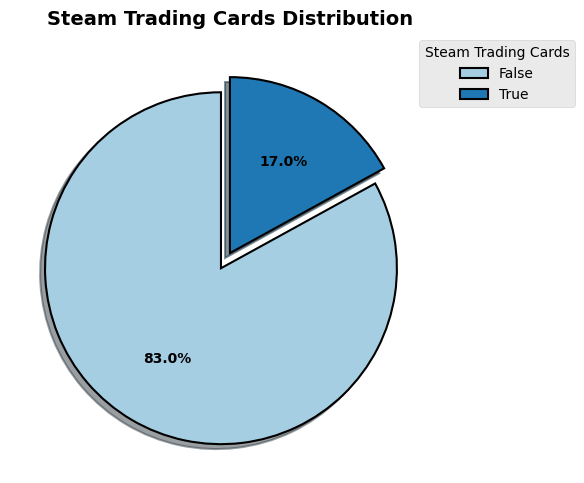

In [18]:
steam_trading_cards_counts = df['steam_trading_cards'].value_counts()
plt.style.use("ggplot")
explode = [0.1 if i == 0 else 0 for i in range(len(steam_trading_cards_counts))]
plt.figure(figsize=(6, 6))
patches, texts, autotexts = plt.pie(
    steam_trading_cards_counts,
    labels=None,  
    autopct='%1.1f%%',
    startangle=90,
    textprops={"fontweight": "bold"},
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    colors=plt.cm.Paired.colors
)

plt.legend(
    patches,
    steam_trading_cards_counts.index,
    loc='upper right',
    bbox_to_anchor=(1.3, 1),
    title="Steam Trading Cards"
)


plt.title('Steam Trading Cards Distribution', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

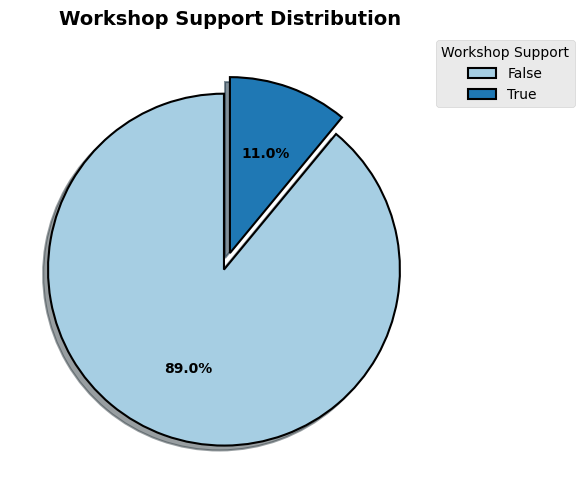

In [19]:
workshop_support_counts = df['workshop_support'].value_counts()
plt.style.use("ggplot")
explode = [0.1 if i == 0 else 0 for i in range(len(workshop_support_counts))]
plt.figure(figsize=(6, 6))
patches, texts, autotexts = plt.pie(
    workshop_support_counts,
    labels=None,  
    autopct='%1.1f%%',
    startangle=90,
    textprops={"fontweight": "bold"},
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    colors=plt.cm.Paired.colors
)

plt.legend(
    patches,
    workshop_support_counts.index,
    loc='upper right',
    bbox_to_anchor=(1.3, 1),
    title="Workshop Support"
)


plt.title('Workshop Support Distribution', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

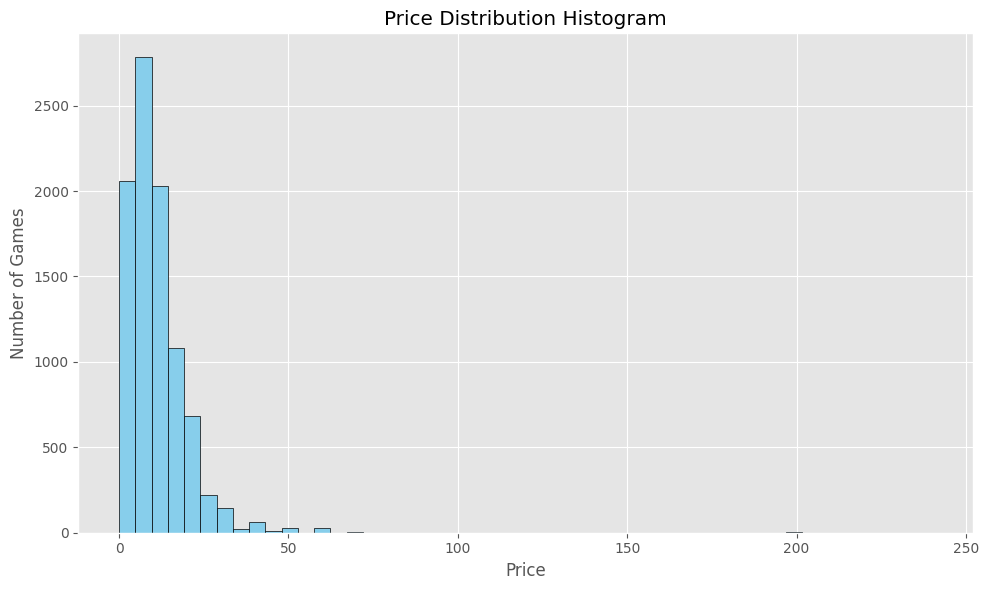

In [20]:
price_counts = df['price'].value_counts().sort_index()
expanded_prices = np.repeat(price_counts.index, price_counts.values)
plt.figure(figsize=(10, 6))
plt.hist(expanded_prices, bins=50, color='skyblue', edgecolor='black')
plt.title('Price Distribution Histogram')
plt.xlabel('Price')
plt.ylabel('Number of Games')
plt.grid(True)
plt.tight_layout()
plt.show()

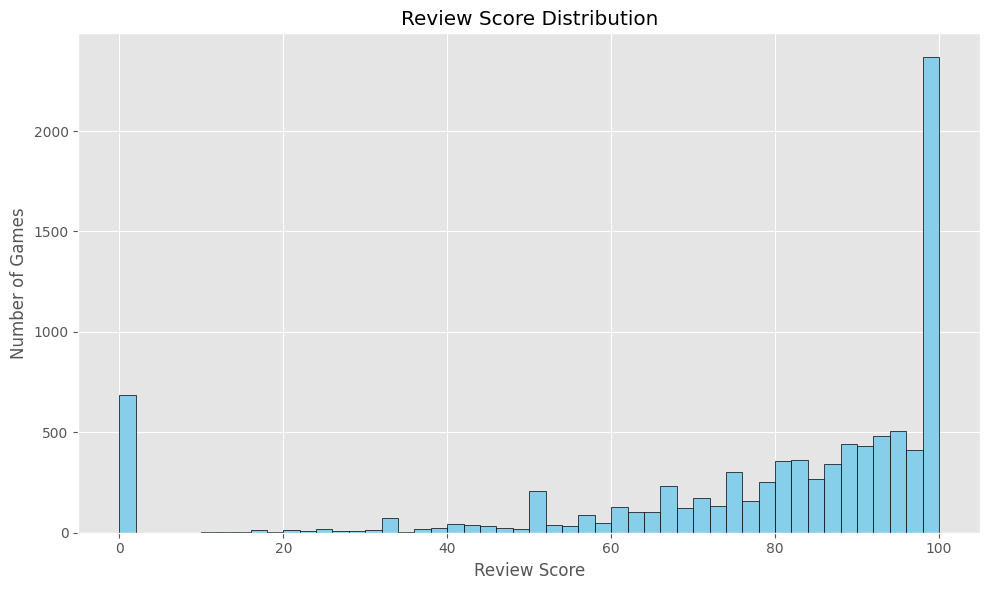

In [21]:
review_score_counts = df['reviewScore'].value_counts().sort_index()
expanded_review_scores = np.repeat(review_score_counts.index, review_score_counts.values)
plt.figure(figsize=(10, 6))
plt.hist(expanded_review_scores, bins=50, color='skyblue', edgecolor='black')  
plt.title('Review Score Distribution')
plt.xlabel('Review Score')
plt.ylabel('Number of Games')
plt.grid(True)
plt.tight_layout()
plt.show()

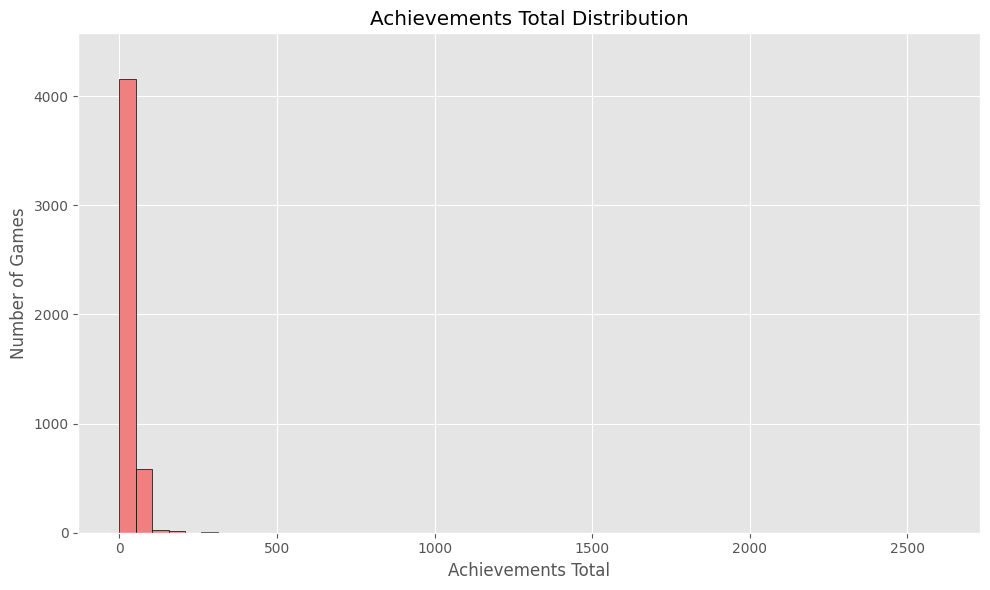

In [22]:
achievements_counts = df['achievements_total'].value_counts().sort_index()
expanded_achievements = np.repeat(achievements_counts.index, achievements_counts.values)
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(expanded_achievements, bins=50, color='lightcoral', edgecolor='black')
plt.title('Achievements Total Distribution')
plt.xlabel('Achievements Total')
plt.ylabel('Number of Games')
plt.ylim(0, max(n) + (max(n) * 0.1))
plt.grid(True)
plt.tight_layout()
plt.show()

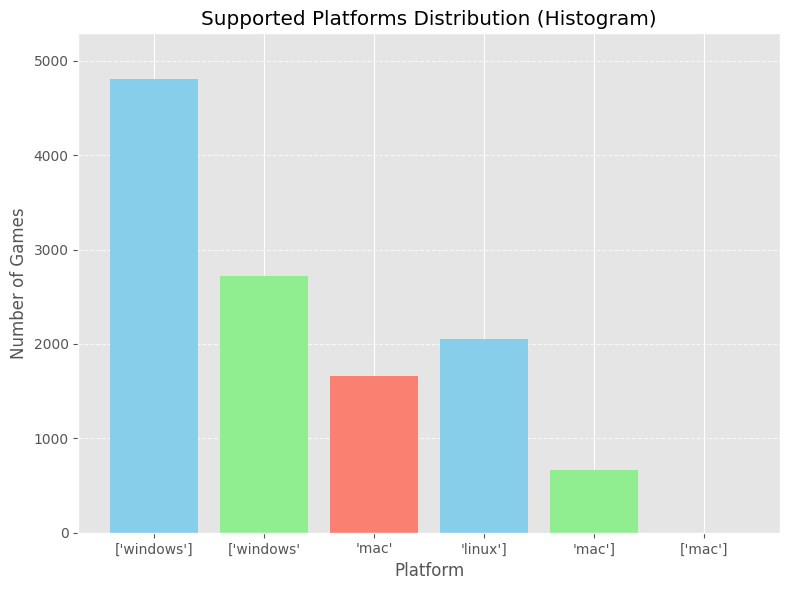

In [23]:
platform_list = []

for platforms in df['supported_platforms']:
    if isinstance(platforms, str):  
        platforms = platforms.lower().split(',')
        platform_list.extend([platform.strip() for platform in platforms])


platform_counts = Counter(platform_list)


plt.figure(figsize=(8, 6))
plt.bar(platform_counts.keys(), platform_counts.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Supported Platforms Distribution (Histogram)')
plt.xlabel('Platform')
plt.ylabel('Number of Games')


max_count = max(platform_counts.values())
plt.ylim(0, max_count + (max_count * 0.1))

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

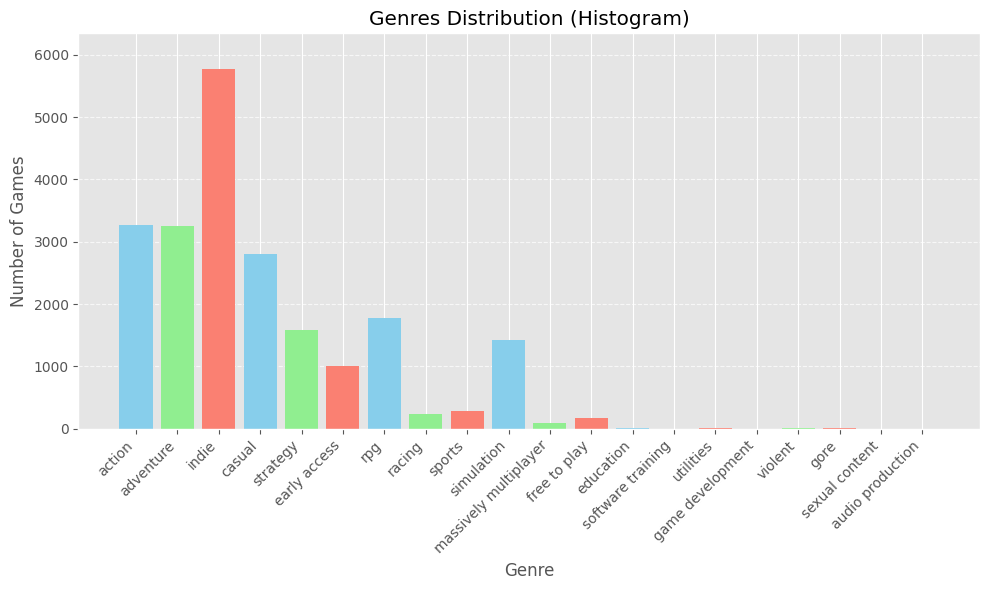

In [24]:
genres_list = []
for genres in df['genres']:
    if isinstance(genres, str): 
        genres = genres.lower().split(',')
        genres_list.extend([genre.strip() for genre in genres])


genres_counts = Counter(genres_list)


plt.figure(figsize=(10, 6))
plt.bar(genres_counts.keys(), genres_counts.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Genres Distribution (Histogram)')
plt.xlabel('Genre')
plt.ylabel('Number of Games')

max_count = max(genres_counts.values())
plt.ylim(0, max_count + (max_count * 0.1)) 

plt.xticks(rotation=45, ha="right") 
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Bivariate Analysis

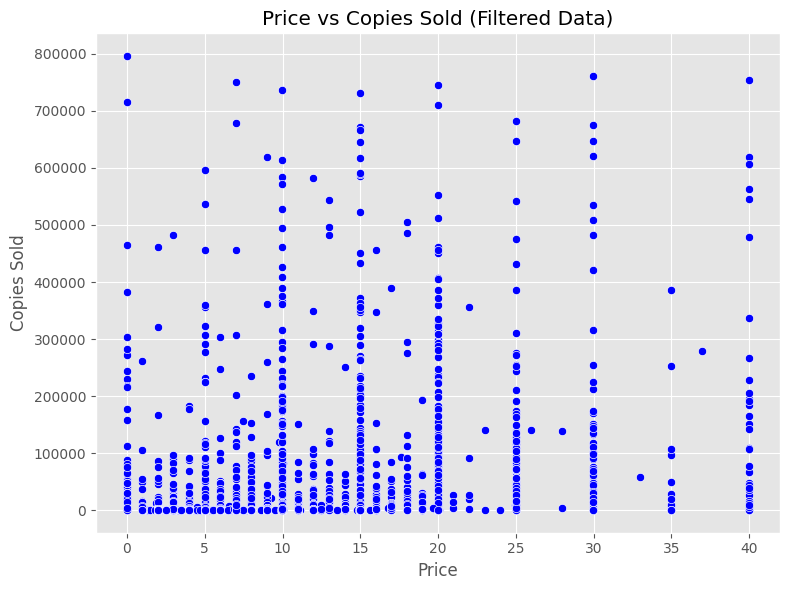

In [25]:
price_threshold = df['price'].quantile(0.99)  
copiesSold_threshold = df['copiesSold'].quantile(0.99)  

filtered_df = df[(df['price'] <= price_threshold) & (df['copiesSold'] <= copiesSold_threshold)]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='price', y='copiesSold', data=filtered_df, color='blue')
plt.title('Price vs Copies Sold (Filtered Data)')
plt.xlabel('Price')
plt.ylabel('Copies Sold')
plt.grid(True)
plt.tight_layout()
plt.show()

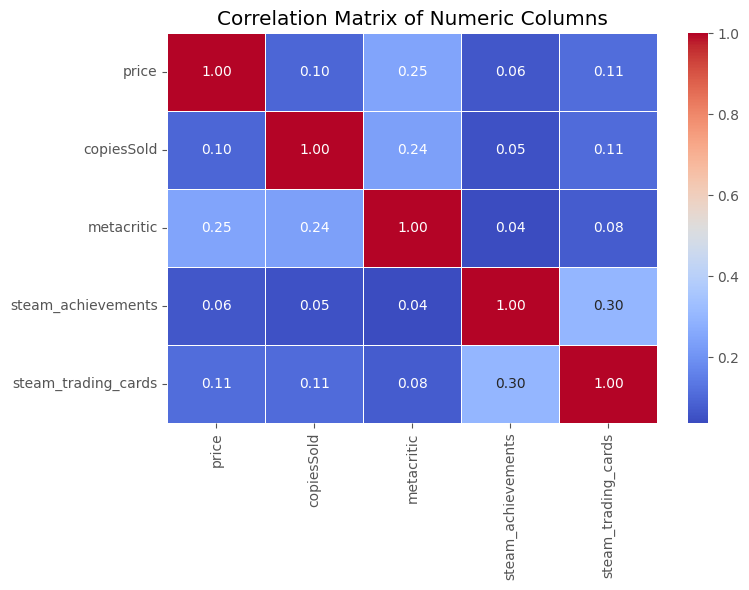

In [26]:
numeric_columns = ['price', 'copiesSold', 'metacritic', 'steam_achievements', 'steam_trading_cards']
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Columns')
plt.tight_layout()
plt.show()

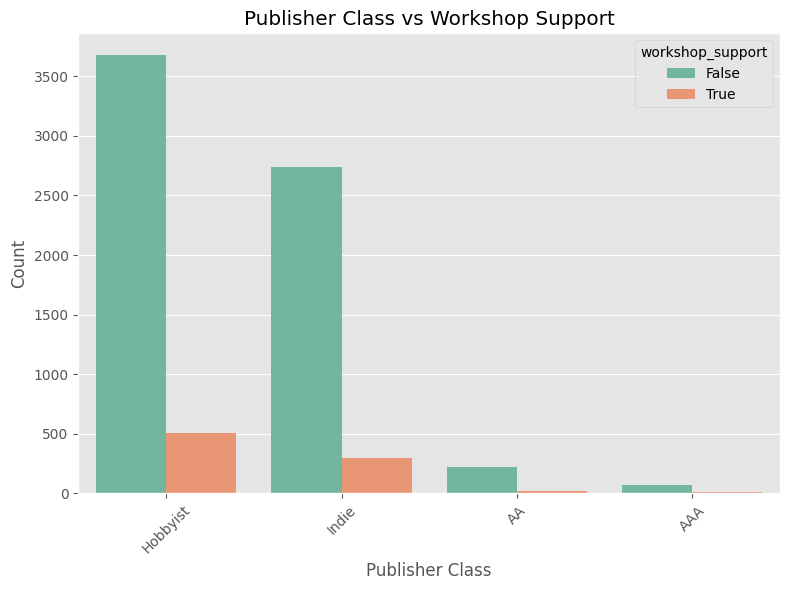

In [27]:
plt.figure(figsize=(8, 6))
sns.countplot(x='publisherClass', hue='workshop_support', data=df, palette='Set2')
plt.title('Publisher Class vs Workshop Support')
plt.xlabel('Publisher Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Additional Visualizations for Preprocessing Decisions

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


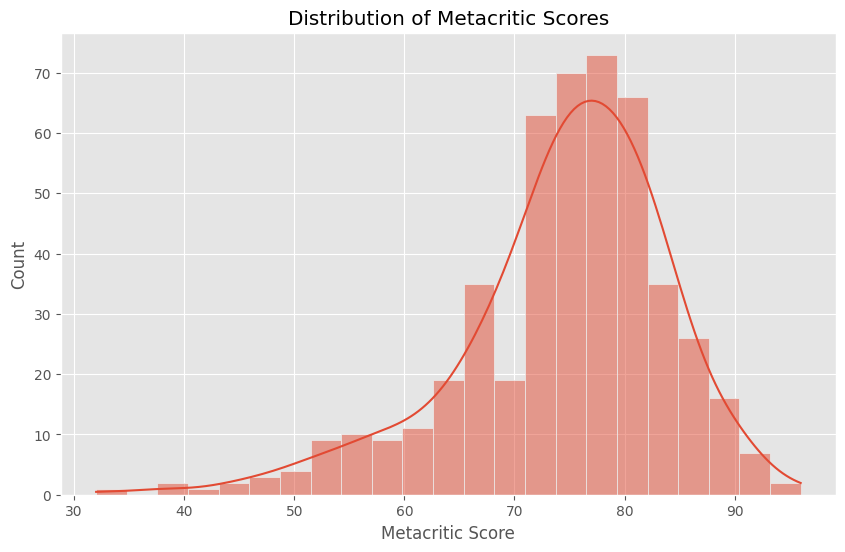

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(df['metacritic'].dropna(), kde=True)
plt.title('Distribution of Metacritic Scores')
plt.xlabel('Metacritic Score')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


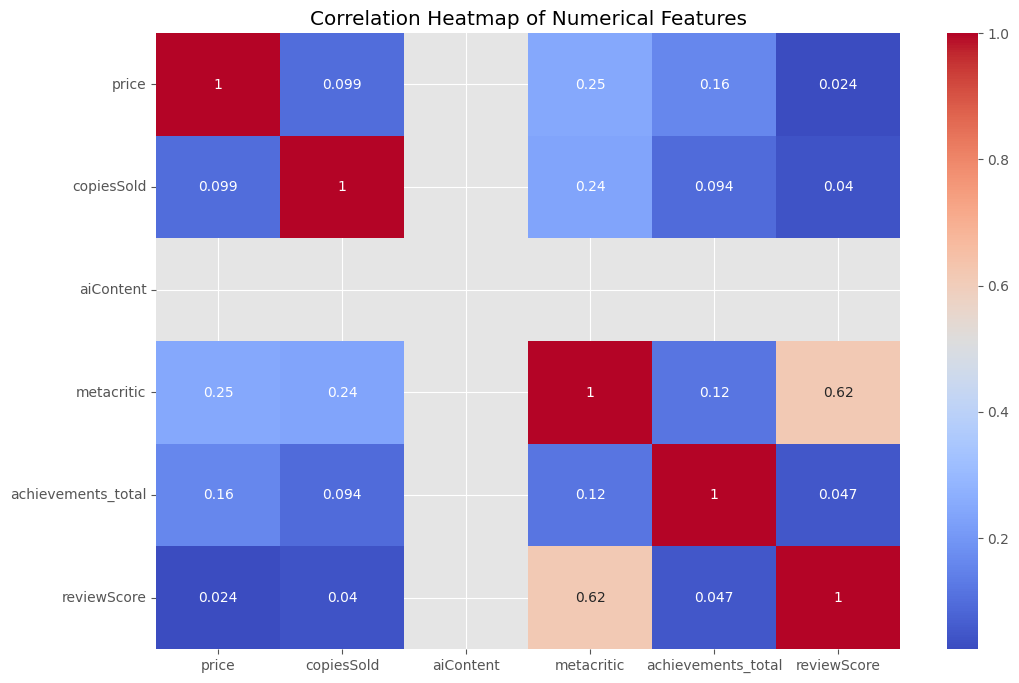

In [29]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## Preprocessing

### Data Cleaning

#### Outliers

In [30]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    df.loc[outliers, col] = df[col].mean()
df.head()

/tmp/ipykernel_14/3648659883.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '46252.78021618081' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers, col] = df[col].mean()
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/tmp/ipykernel_14/3648659883.py:9: FutureWarning: Setting an item of incompatib

,name_x,name_y,price,copiesSold,publisherClass,aiContent,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms,reviewScore
0,Rolando Deluxe Demo,NaN,9.99,58.0,Hobbyist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
1,Outrunner: Neon Nights Demo,NaN,9.99,60.0,Hobbyist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
2,Bubble Ghost Remake Demo,NaN,19.99,253.0,Indie,NaN,Bubble Ghost Remake,NaN,True,False,False,"Action, Adventure, Indie",NaN,"Mar 26, 2025",['windows'],100.0
3,Time Handlers Demo,NaN,13.99,174.0,Hobbyist,NaN,Time Handlers,NaN,True,False,False,"Adventure, Indie",32.0,"Jan 11, 2024","['windows', 'mac', 'linux']",75.0
4,Musical Vibes Demo,NaN,11.99,8.0,Hobbyist,NaN,Musical Vibes,NaN,False,False,False,Casual,NaN,"Nov 1, 2023",['windows'],100.0


#### Name

In [31]:
df['achievements_total'] = df['achievements_total'].fillna(0)
df['genres'] = df['genres'].fillna(df['genres'].mode()[0])
print(df.columns)
df = df.dropna(subset=['release_date'])
columns_to_drop = ['metacritic']
df = df.drop(columns=columns_to_drop)
df = df.drop_duplicates()
print("Shape after Previous preprocessing:", df.shape)
print("\nMissing values after preprocessing:")
print(df.isna().sum())

Index(['name_x', 'name_y', 'price', 'copiesSold', 'publisherClass',
       'aiContent', 'name', 'metacritic', 'steam_achievements',
       'steam_trading_cards', 'workshop_support', 'genres',
       'achievements_total', 'release_date', 'supported_platforms',
       'reviewScore'],
      dtype='object')
Shape after Previous preprocessing: (7535, 15)

Missing values after preprocessing:
name_x                    1
name_y                 7015
price                     0
copiesSold                0
publisherClass            0
aiContent              7535
name                      0
steam_achievements        0
steam_trading_cards       0
workshop_support          0
genres                    0
achievements_total        0
release_date              0
supported_platforms       0
reviewScore               0
dtype: int64


In [32]:
df['name'] = df['name'].fillna('Unknown Game') 
df['name'] = df['name'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
df['name'] = df['name'].str.lower()
df['name'] = df['name'].str.strip()
df['name_tokens'] = df['name'].str.split()
df['name_length'] = df['name'].apply(len)
df[['name', 'name_tokens', 'name_length']].head()

,name,name_tokens,name_length
2,bubble ghost remake,"[bubble, ghost, remake]",19
3,time handlers,"[time, handlers]",13
4,musical vibes,"[musical, vibes]",13
6,nudel tag,"[nudel, tag]",9
8,throne of bone,"[throne, of, bone]",14


#### Date

Missing values in 'year': 0
Missing values in 'day': 0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


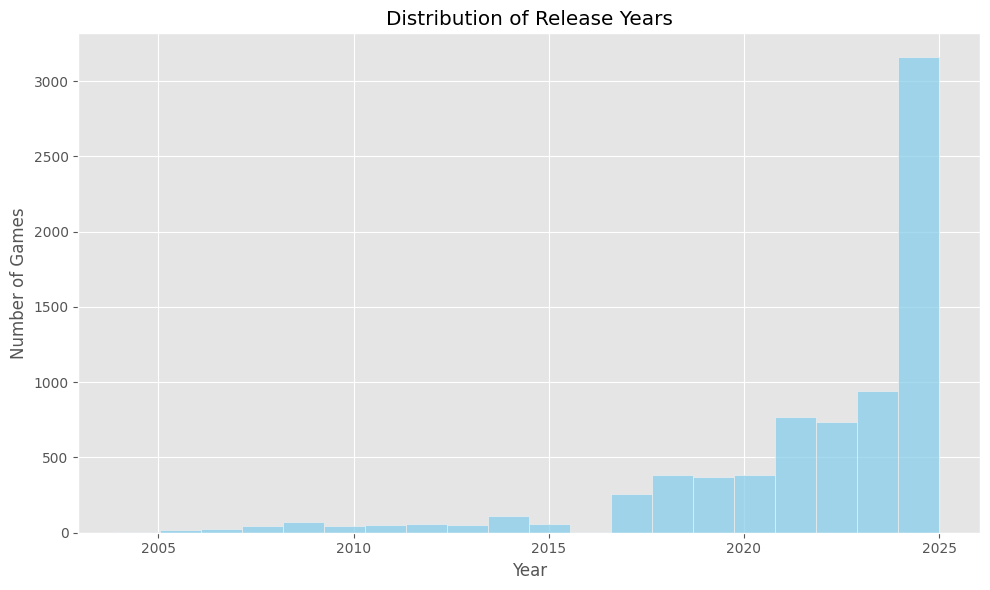

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


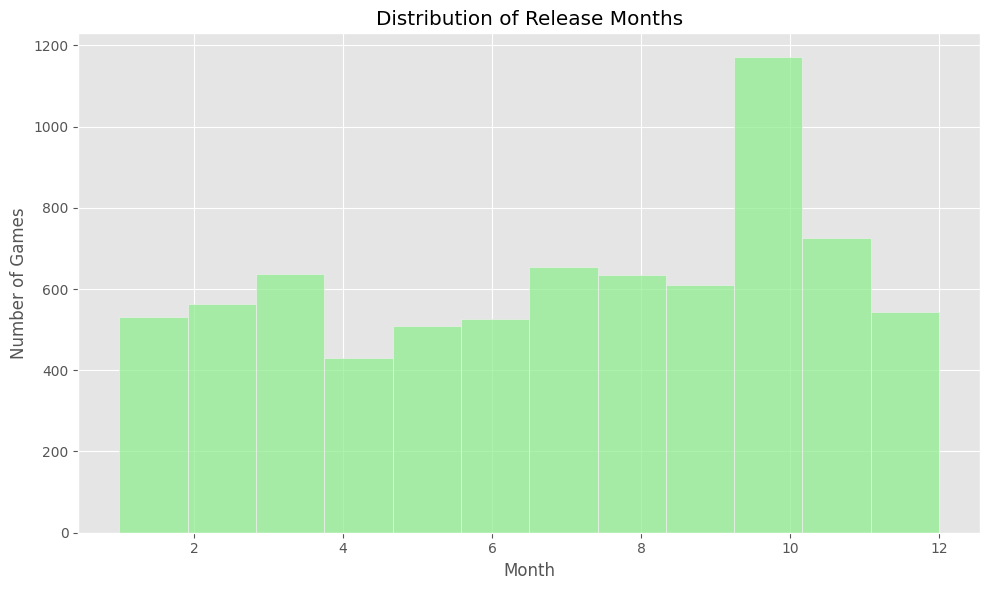

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


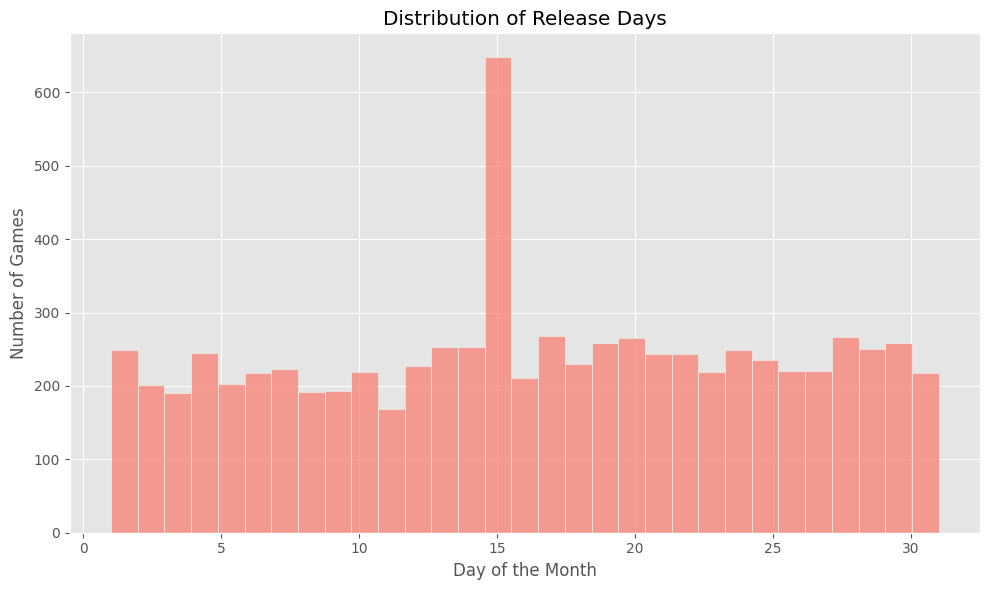

In [33]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

df['year'] = df['release_date'].dt.year  
df['month'] = df['release_date'].dt.month  
df['day'] = df['release_date'].dt.day 

df['year'] = df['year'].fillna(df['year'].mode()[0])
df['day'] = df['day'].fillna(df['day'].mode()[0])
df['month'] = df['month'].fillna(df['month'].mode()[0])


print(f"Missing values in 'year': {df['year'].isnull().sum()}")
print(f"Missing values in 'day': {df['day'].isnull().sum()}")


df = df.drop('release_date', axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(df['year'], kde=False, bins=20, color='skyblue')
plt.title('Distribution of Release Years')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['month'], kde=False, bins=12, color='lightgreen')
plt.title('Distribution of Release Months')
plt.xlabel('Month')
plt.ylabel('Number of Games')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['day'], kde=False, bins=31, color='salmon')
plt.title('Distribution of Release Days')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Games')
plt.grid(True)
plt.tight_layout()
plt.show()

### Encoding

#### Boolean Features

In [34]:
 bool_features = ['steam_achievements', 'steam_trading_cards', 'workshop_support']
for feature in bool_features:
    df[feature] = df[feature].astype(int)

#### Publisher Class

In [35]:
label_encoder = LabelEncoder()
df['publisher_class_encoded'] = label_encoder.fit_transform(df['publisherClass'])
df[['publisherClass', 'publisher_class_encoded']].head()
df.drop(columns='publisherClass',inplace=True)
print(df.columns)

Index(['name_x', 'name_y', 'price', 'copiesSold', 'aiContent', 'name',
       'steam_achievements', 'steam_trading_cards', 'workshop_support',
       'genres', 'achievements_total', 'supported_platforms', 'reviewScore',
       'name_tokens', 'name_length', 'year', 'month', 'day',
       'publisher_class_encoded'],
      dtype='object')


#### Genres

In [36]:
genres = df['genres'].str.split(',', expand=True)
genre_columns = []

unique_genres = pd.unique(genres.values.ravel())

for genre in unique_genres:
    df[genre] = genres.apply(lambda row: 1 if genre in row.values else 0, axis=1)
    genre_columns.append(genre)

df = df.drop('genres', axis=1)

df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,name_x,name_y,price,copiesSold,aiContent,name,steam_achievements,steam_trading_cards,workshop_support,achievements_total,...,Software Training,Utilities,Game Development,Violent,Action,Gore,Sexual Content,Violent,Gore,Audio Production
2,Bubble Ghost Remake Demo,NaN,19.99,253.0,NaN,bubble ghost remake,1,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Time Handlers Demo,NaN,13.99,174.0,NaN,time handlers,1,0,0,32.0,...,0,0,0,0,0,0,0,0,0,0
4,Musical Vibes Demo,NaN,11.99,8.0,NaN,musical vibes,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,Nudel Tag Demo,NaN,6.49,1.0,NaN,nudel tag,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
8,Throne of Bone Demo,NaN,16.99,8167.0,NaN,throne of bone,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### Supported Platforms

In [37]:
platforms = df['supported_platforms'].str.split(',', expand=True)

df['windows'] = platforms[0].apply(lambda x: 1 if pd.notna(x) and 'windows' in x.lower() else 0)
df['linux'] = platforms[1].apply(lambda x: 1 if pd.notna(x) and 'linux' in x.lower() else 0)
df['mac'] = platforms[2].apply(lambda x: 1 if pd.notna(x) and 'mac' in x.lower() else 0)

df = df.drop('supported_platforms', axis=1)


df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,name_x,name_y,price,copiesSold,aiContent,name,steam_achievements,steam_trading_cards,workshop_support,achievements_total,...,Violent,Action,Gore,Sexual Content,Violent,Gore,Audio Production,windows,linux,mac
2,Bubble Ghost Remake Demo,NaN,19.99,253.0,NaN,bubble ghost remake,1,0,0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,Time Handlers Demo,NaN,13.99,174.0,NaN,time handlers,1,0,0,32.0,...,0,0,0,0,0,0,0,1,0,0
4,Musical Vibes Demo,NaN,11.99,8.0,NaN,musical vibes,0,0,0,0.0,...,0,0,0,0,0,0,0,1,0,0
6,Nudel Tag Demo,NaN,6.49,1.0,NaN,nudel tag,0,0,0,0.0,...,0,0,0,0,0,0,0,1,0,0
8,Throne of Bone Demo,NaN,16.99,8167.0,NaN,throne of bone,0,0,0,0.0,...,0,0,0,0,0,0,0,1,0,0


#### Scaling

In [38]:
columns_to_scale = [col for col in numeric_columns if col not in genre_columns]
columns_to_scale.remove('metacritic')

X_numeric = df[columns_to_scale]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
y = df['reviewScore']

X_scaled_df = pd.DataFrame(X_scaled, columns=X_numeric.columns)

X_final = pd.concat([X_scaled_df, df[genre_columns]], axis=1)


df_scaled = pd.concat([X_final, y], axis=1)


df_scaled.head()
df[df_scaled.columns] = df_scaled

In [39]:
df_scaled.describe()

,price,copiesSold,steam_achievements,steam_trading_cards,Action,Adventure,Indie,None,Adventure,Casual,...,Utilities,Game Development,Violent,Action,Gore,Sexual Content,Violent,Gore,Audio Production,reviewScore
count,7.535000e+03,7.535000e+03,7.535000e+03,7.535000e+03,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,...,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000
mean,-6.412330e-17,-4.903546e-17,1.885979e-17,-3.017567e-17,0.432515,0.203185,0.653749,0.999867,0.228799,0.159788,...,0.000531,0.000133,0.001327,0.001062,0.000265,0.000398,0.000398,0.000929,0.000133,84.236670
std,1.000066e+00,1.000066e+00,1.000066e+00,1.000066e+00,0.495458,0.402396,0.475806,0.011520,0.420087,0.366433,...,0.023036,0.011520,0.036408,0.032569,0.016291,0.019951,0.019951,0.030467,0.011520,15.361992
min,-1.510790e+00,-5.178749e-01,-1.298566e+00,-4.525803e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000
25%,-6.727547e-01,-5.152207e-01,-1.298566e+00,-4.525803e-01,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,77.937875
50%,-1.689259e-01,-4.960644e-01,7.700800e-01,-4.525803e-01,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.000000
75%,5.028458e-01,-3.048189e-01,7.700800e-01,-4.525803e-01,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.000000
max,2.854047e+00,2.150895e+00,7.700800e-01,2.209553e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [40]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,name_x,name_y,price,copiesSold,aiContent,name,steam_achievements,steam_trading_cards,workshop_support,achievements_total,...,Violent,Action,Gore,Sexual Content,Violent,Gore,Audio Production,windows,linux,mac
2,Bubble Ghost Remake Demo,NaN,0.502846,-0.517413,NaN,bubble ghost remake,-1.298566,-0.452580,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
3,Time Handlers Demo,NaN,-0.420840,-0.517817,NaN,time handlers,-1.298566,-0.452580,0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
4,Musical Vibes Demo,NaN,1.342561,-0.046642,NaN,musical vibes,-1.298566,-0.452580,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
6,Nudel Tag Demo,NaN,0.670789,-0.517009,NaN,nudel tag,0.770080,2.209553,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
8,Throne of Bone Demo,NaN,2.686104,-0.357989,NaN,throne of bone,0.770080,2.209553,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0


## Feature Engineering and Selection

### Total genres Feature

In [41]:
df['Total_Genres'] = df[genre_columns].sum(axis=1)
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,name_x,name_y,price,copiesSold,aiContent,name,steam_achievements,steam_trading_cards,workshop_support,achievements_total,...,Action,Gore,Sexual Content,Violent,Gore,Audio Production,windows,linux,mac,Total_Genres
2,Bubble Ghost Remake Demo,NaN,0.502846,-0.517413,NaN,bubble ghost remake,-1.298566,-0.452580,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,4.0
3,Time Handlers Demo,NaN,-0.420840,-0.517817,NaN,time handlers,-1.298566,-0.452580,0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,3.0
4,Musical Vibes Demo,NaN,1.342561,-0.046642,NaN,musical vibes,-1.298566,-0.452580,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,2.0
6,Nudel Tag Demo,NaN,0.670789,-0.517009,NaN,nudel tag,0.770080,2.209553,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,3.0
8,Throne of Bone Demo,NaN,2.686104,-0.357989,NaN,throne of bone,0.770080,2.209553,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,3.0


In [42]:
zero_genres = (df['Total_Genres']==0).sum()
print(zero_genres)

0


### Number of Platforms Feature

In [43]:
platforms_columns = ['windows','linux','mac']
df['Total_Platforms'] = df[platforms_columns].sum(axis=1)

In [44]:
zero_platforms = (df['Total_Platforms']== 0 ).sum()
print(zero_platforms)
df = df[df['Total_Platforms']!=0]
zero_platforms_after = (df['Total_Platforms']== 0 ).sum()
print(zero_platforms_after)

1
0


### Columns With Too much nulls

In [45]:
df.drop(columns=['name_x','name_y','aiContent'],inplace=True)
print(df.columns)

Index([                  'price',              'copiesSold',
                          'name',      'steam_achievements',
           'steam_trading_cards',        'workshop_support',
            'achievements_total',             'reviewScore',
                   'name_tokens',             'name_length',
                          'year',                   'month',
                           'day', 'publisher_class_encoded',
                        'Action',              ' Adventure',
                        ' Indie',                      None,
                     'Adventure',                  'Casual',
                       ' Casual',                'Strategy',
                 ' Early Access',                    ' RPG',
                         'Indie',                 ' Racing',
                       ' Sports',               ' Strategy',
                   ' Simulation',                  'Sports',
        ' Massively Multiplayer',            'Early Access',
                        

### Useless features

In [46]:
df.drop(columns=['name','name_tokens','name_length'],inplace=True)
print(df.columns)

Index([                  'price',              'copiesSold',
            'steam_achievements',     'steam_trading_cards',
              'workshop_support',      'achievements_total',
                   'reviewScore',                    'year',
                         'month',                     'day',
       'publisher_class_encoded',                  'Action',
                    ' Adventure',                  ' Indie',
                            None,               'Adventure',
                        'Casual',                 ' Casual',
                      'Strategy',           ' Early Access',
                          ' RPG',                   'Indie',
                       ' Racing',                 ' Sports',
                     ' Strategy',             ' Simulation',
                        'Sports',  ' Massively Multiplayer',
                  'Early Access',                     'RPG',
                    'Simulation',            'Free To Play',
         'Massively Mult

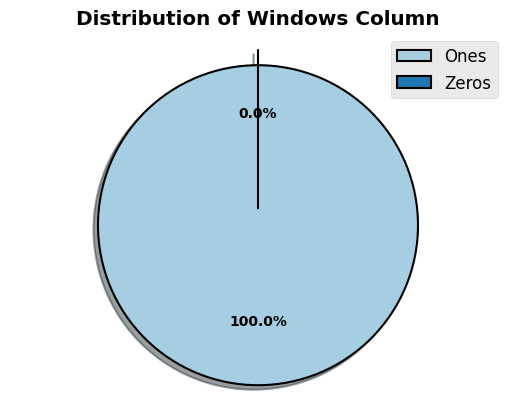

In [47]:
ones_count = df['windows'].sum()
zeros_count = len(df) - ones_count


sizes = [ones_count, zeros_count]
labels = ['Ones', 'Zeros']


explode = (0.1, 0) 
patches, texts, autotexts = plt.pie(
    sizes,
    labels=None, 
    autopct='%1.1f%%',
    startangle=90,
    textprops={"fontweight": "bold"},
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    colors=plt.cm.Paired.colors
)


plt.legend(patches, labels, loc="best", fontsize='large', frameon=True)
plt.title('Distribution of Windows Column', fontweight='bold')
plt.axis('equal')  
plt.show()
df.drop(columns='windows',inplace=True)

(-1.099999760366562,
 1.099999875007818,
 -1.1049306256324951,
 1.2035500392688798)

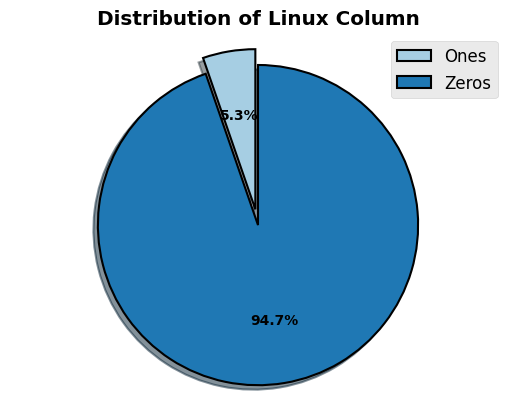

In [48]:
ones_count = df['linux'].sum()
zeros_count = len(df) - ones_count


sizes = [ones_count, zeros_count]
labels = ['Ones', 'Zeros']


explode = (0.1, 0) 
patches, texts, autotexts = plt.pie(
    sizes,
    labels=None,  
    autopct='%1.1f%%',
    startangle=90,
    textprops={"fontweight": "bold"},
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    colors=plt.cm.Paired.colors
)

plt.legend(patches, labels, loc="best", fontsize='large', frameon=True)
plt.title('Distribution of Linux Column', fontweight='bold')
plt.axis('equal')

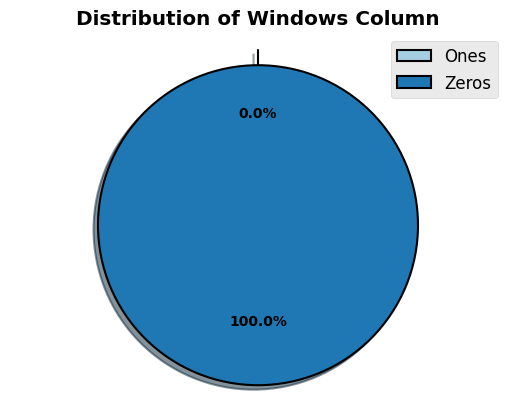

In [49]:
ones_count = df['mac'].sum()
zeros_count = len(df) - ones_count


sizes = [ones_count, zeros_count]
labels = ['Ones', 'Zeros']


explode = (0.1, 0)  
patches, texts, autotexts = plt.pie(
    sizes,
    labels=None,  
    autopct='%1.1f%%',
    startangle=90,
    textprops={"fontweight": "bold"},
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    colors=plt.cm.Paired.colors
)

# Add a legend instead of labels
plt.legend(patches, labels, loc="best", fontsize='large', frameon=True)
plt.title('Distribution of Windows Column', fontweight='bold')
plt.axis('equal')  # Make it a circle
df.drop(columns='mac',inplace=True)

### Correlation

In [50]:
numeric_columns = df.select_dtypes(include=['number']).columns
print(df.columns)
df_numeric = df[numeric_columns]
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')
corr_matrix = df_numeric.corr()
threshold = 0.5
target = 'reviewScore'
if target in corr_matrix.columns:
    
    target_correlations = corr_matrix[target].drop(target).sort_values(key=abs, ascending=False)
    
    target_report = pd.DataFrame({
        'Feature': target_correlations.index,
        'Correlation': target_correlations.values,
        'Absolute_Correlation': target_correlations.abs().values,
        'Significant': target_correlations.abs() >= threshold
    })
    
    print(f"TARGET-ORIENTED FEATURE ANALYSIS (for '{target}')\n")
    print("="*70)
    print(target_report.to_string(index=False))
    
    significant_target_features = target_correlations[target_correlations.abs() >= threshold].index.tolist()
    print(f"Significant features for prediction (|r| ≥ {threshold}):")
    print(significant_target_features)
    print("\n\n")

print("CROSS-FEATURE CORRELATION ANALYSIS")
print("="*70)

significant_corrs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        val = corr_matrix.iloc[i, j]
        if abs(val) >= threshold:
            significant_corrs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': val
            })

results_df = pd.DataFrame(significant_corrs)
results_df['abs_corr'] = results_df['Correlation'].abs()
results_df = results_df.sort_values('abs_corr', ascending=False).drop('abs_corr', axis=1)

print(f"Significant Correlations Between Features (|r| ≥ {threshold}):\n")
print("="*70)
print(results_df.to_string(index=False))

if target in corr_matrix.columns:
    print("FEATURE SELECTION RECOMMENDATIONS\n\n")
    print("="*70)
    print("HIGH-VALUE FEATURES (keep these):\n")
    high_value = target_report[target_report['Significant']].sort_values('Absolute_Correlation', ascending=False)
    print(high_value[['Feature', 'Correlation']].to_string(index=False))
    
    print("LOW-VALUE FEATURES (consider removing):\n")
    low_value = target_report[~target_report['Significant']].sort_values('Absolute_Correlation', ascending=False)
    print(low_value[['Feature', 'Correlation']].to_string(index=False))
    
    redundant_features = set()
    for _, row in results_df.iterrows():
        if target not in [row['Feature 1'], row['Feature 2']]:
            if row['Feature 1'] in high_value['Feature'].values and row['Feature 2'] in high_value['Feature'].values:
                redundant_features.add(row['Feature 2']) 
    
    if redundant_features:
        print("POTENTIALLY REDUNDANT FEATURES (consider removing one of each pair):\n")
        print(list(redundant_features))

print("SUMMARY STATISTICS\n")
print("="*70)
print(f"- Total features analyzed: {len(corr_matrix.columns)}")
if target in corr_matrix.columns:
    print(f"- Features strongly correlated with target ({threshold}+): {len(high_value)}")
    print(f"- Features weakly correlated with target: {len(low_value)}")
print(f"- Significant cross-feature correlations found: {len(results_df)}")

Index([                  'price',              'copiesSold',
            'steam_achievements',     'steam_trading_cards',
              'workshop_support',      'achievements_total',
                   'reviewScore',                    'year',
                         'month',                     'day',
       'publisher_class_encoded',                  'Action',
                    ' Adventure',                  ' Indie',
                            None,               'Adventure',
                        'Casual',                 ' Casual',
                      'Strategy',           ' Early Access',
                          ' RPG',                   'Indie',
                       ' Racing',                 ' Sports',
                     ' Strategy',             ' Simulation',
                        'Sports',  ' Massively Multiplayer',
                  'Early Access',                     'RPG',
                    'Simulation',            'Free To Play',
         'Massively Mult

### Redundant

In [51]:
df.drop(columns=['Violent', 'Gore', 'workshop_support', 'Adventure', 'linux'], inplace=True)
print(df.columns)

Index([                  'price',              'copiesSold',
            'steam_achievements',     'steam_trading_cards',
            'achievements_total',             'reviewScore',
                          'year',                   'month',
                           'day', 'publisher_class_encoded',
                        'Action',              ' Adventure',
                        ' Indie',                      None,
                        'Casual',                 ' Casual',
                      'Strategy',           ' Early Access',
                          ' RPG',                   'Indie',
                       ' Racing',                 ' Sports',
                     ' Strategy',             ' Simulation',
                        'Sports',  ' Massively Multiplayer',
                  'Early Access',                     'RPG',
                    'Simulation',            'Free To Play',
         'Massively Multiplayer',           ' Free To Play',
                        

## PCA

In [52]:
apply_pca = True  
print("\nChecking for missing values in the selected features:")
print(df.isna().sum())


if 'reviewScore' in df.columns:
    df = df.dropna(subset=['reviewScore'])  
print("\nFilling missing values for categorical columns...")
for col in tqdm(df.columns[df.dtypes == 'object'], desc="Categorical columns", leave=False):
    df[col] = df[col].fillna(df[col].mode()[0])


print("\nFilling missing values for numeric columns...")
for col in tqdm(df.select_dtypes(include=['number']).columns, desc="Numeric columns", leave=False):
    df[col] = df[col].fillna(df[col].mean())


df_selected = df.select_dtypes(include=['number'])  


print("\nTotal NaN after filling missing values:")
print(df_selected.isnull().sum().sum())
df_selected.columns = df_selected.columns.astype(str)


if apply_pca:
    print("\nApplying PCA...")
    pca = PCA(n_components=3)

    
    with tqdm(total=1, desc="PCA fitting", leave=False) as pbar:
        df_pca = pca.fit_transform(df_selected)
        pbar.update(1)

 
    df_pca_df = pd.DataFrame(df_pca, columns=[f'PCA_{i+1}' for i in range(df_pca.shape[1])])


    print("\nVariance Ratio per PCA Component:")
    for i, var_ratio in enumerate(pca.explained_variance_ratio_):
        print(f"PCA_{i+1}: {var_ratio:.4f}")

   
    feature_loadings = pd.DataFrame(
        pca.components_.T,  
        columns=[f'PCA_{i+1}' for i in range(pca.n_components_)],
        index=df_selected.columns
    )
abs_loadings = abs(df.corr())
pca_top_3_features = abs_loadings.sum(axis=1).nlargest(3).index.tolist()


if 'reviewScore' in pca_top_3_features:
    pca_top_3_features.remove('reviewScore')


if len(pca_top_3_features) < 3:
    additional_feature = abs_loadings.sum(axis=1).nlargest(3 + len(pca_top_3_features)).index[-1]
    pca_top_3_features.append(additional_feature)


print("Top 3 features PCA selected: ", pca_top_3_features)


Checking for missing values in the selected features:
price                      1369
copiesSold                 1369
steam_achievements         1369
steam_trading_cards        1369
achievements_total            0
reviewScore                   0
year                          0
month                         0
day                           0
publisher_class_encoded       0
Action                        0
 Adventure                    0
 Indie                        0
None                          0
Casual                        0
 Casual                       0
Strategy                      0
 Early Access                 0
 RPG                          0
Indie                         0
 Racing                       0
 Sports                       0
 Strategy                     0
 Simulation                   0
Sports                        0
 Massively Multiplayer        0
Early Access                  0
RPG                           0
Simulation                    0
Free To Play     

Categorical columns: 0it [00:00, ?it/s]


Filling missing values for numeric columns...


Numeric columns:   0%|          | 0/44 [00:00<?, ?it/s]


Total NaN after filling missing values:
0

Applying PCA...


PCA fitting:   0%|          | 0/1 [00:00<?, ?it/s]


Variance Ratio per PCA Component:
PCA_1: 0.4763
PCA_2: 0.3596
PCA_3: 0.1159
Top 3 features PCA selected:  ['Total_Genres', 'Action', ' Indie']


## Recursive Feature Elimination (RFE)

In [53]:
X = df.select_dtypes(include=['number']) 
y = df['reviewScore']

X.columns = X.columns.astype(str)  

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

model = RandomForestRegressor(random_state=42)
selector = RFE(estimator=model, n_features_to_select=5)


with tqdm(total=1, desc="RFE Feature Selection Progress", unit="step") as pbar:
    selector.fit(X_imputed, y)  
    pbar.update(1)  


rfe_selected_features = X.columns[selector.support_]
print(f"Top 5 features selected by RFE: {rfe_selected_features}")

RFE Feature Selection Progress:   0%|          | 0/1 [00:00<?, ?step/s]

Top 5 features selected by RFE: Index(['price', 'reviewScore', 'year', 'month', 'day'], dtype='object')


In [54]:
final_df = df[['Total_Genres', 'Action',' Indie','copiesSold', 'year', 'reviewScore']]
final_df.to_csv('/kaggle/working/preprocessed.csv', index=False)

## Data Splitting

In [55]:
X = df[['Total_Genres', 'Action',' Indie','copiesSold', 'year', ' Sports']]
X = X.fillna(X.median())
y = df['reviewScore'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Regression Models

## XGBoost

XGBoost MSE: 250.40510129904803
XGBoost MAE: 12.509322039434805
XGBoost R²: -0.08756674229757677


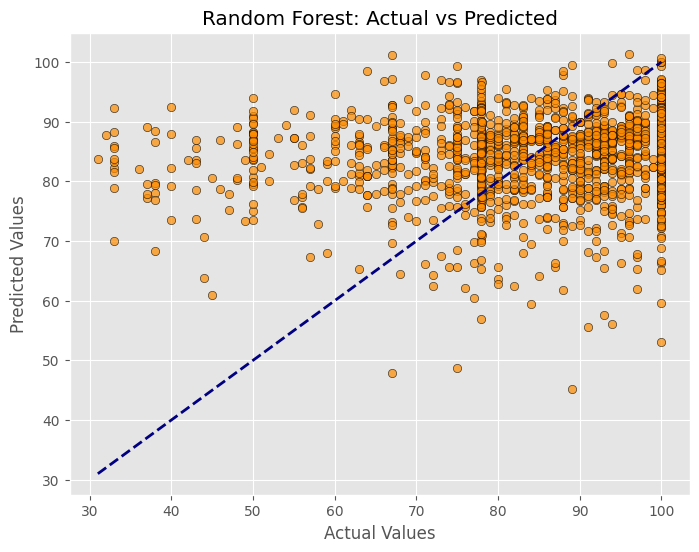

In [56]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost R²: {r2_xgb}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, color='darkorange', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='navy', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Actual vs Predicted')
plt.grid(True)
plt.show()

## Random Forest

Random Forest MSE: 264.8540
Random Forest MAE: 12.8061
Random Forest R²: -0.1503


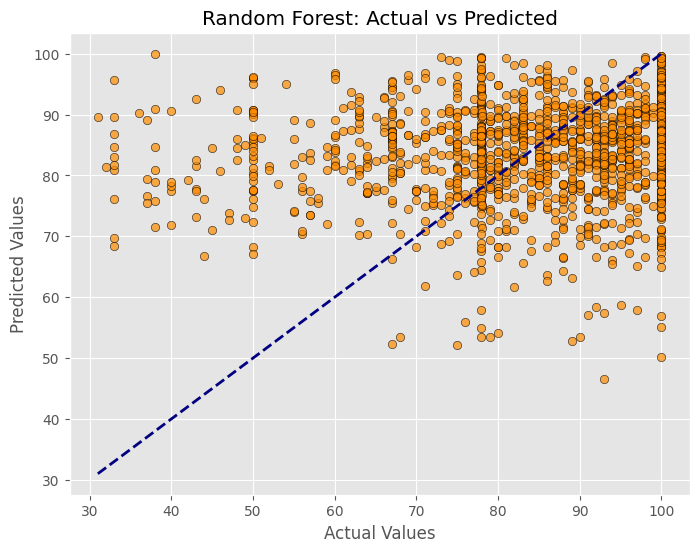

In [57]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf:.4f}")
print(f"Random Forest MAE: {mae_rf:.4f}")
print(f"Random Forest R²: {r2_rf:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, color='darkorange', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='navy', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Actual vs Predicted')
plt.grid(True)
plt.show()

## Multilayer Perceptron (MLP) Regressor

MLP MSE: 233.7760
MLP MAE: 11.8727
MLP R²: -0.0153


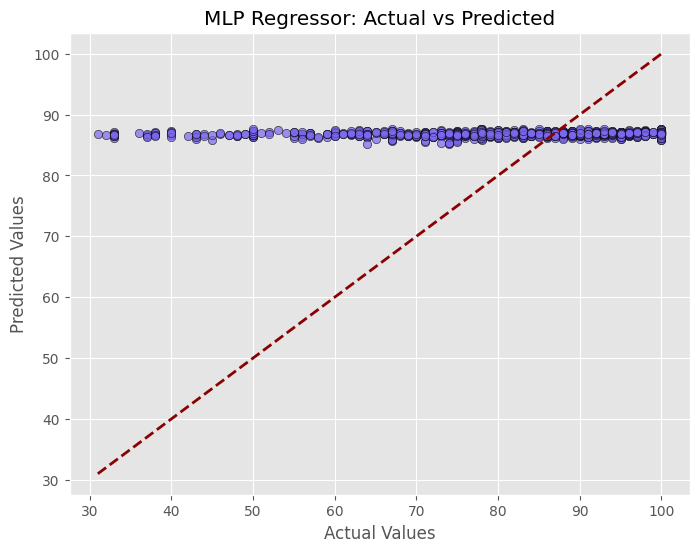

In [58]:
mlp_model = MLPRegressor(random_state=42)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

mse_mlp = mean_squared_error(y_test, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f"MLP MSE: {mse_mlp:.4f}")
print(f"MLP MAE: {mae_mlp:.4f}")
print(f"MLP R²: {r2_mlp:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_mlp, color='mediumslateblue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='darkred', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('MLP Regressor: Actual vs Predicted')
plt.grid(True)
plt.show()

## KNN Regressor

KNN MSE: 257.4675120194637
KNN MAE: 12.393237468876364
R² KNN: -0.11824041060594359


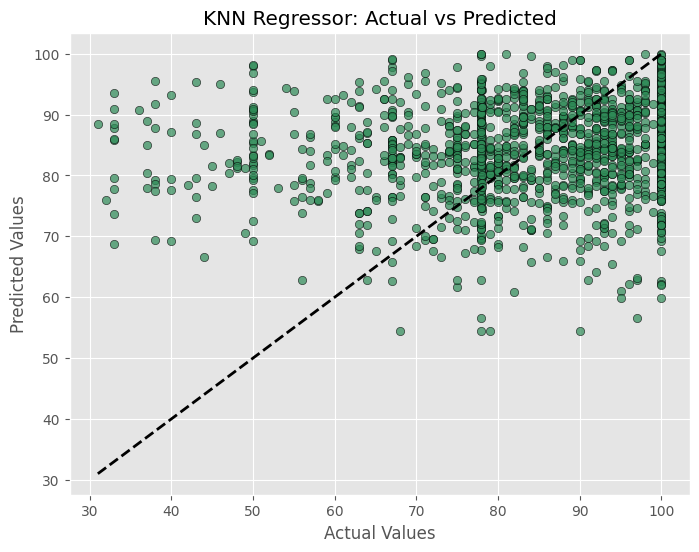

In [59]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2 = r2_score(y_test, y_pred_knn)
print(f"KNN MSE: {mse_knn}")
print(f"KNN MAE: {mae_knn}")
print(f"R² KNN: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_knn, color='seagreen', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('KNN Regressor: Actual vs Predicted')
plt.grid(True)
plt.show()

## Polynomial Regression

Polynomial Regression MSE: 213.68281021869404
Polynomial Regression MAE: 213.68281021869404
R²: 0.07192658380789962


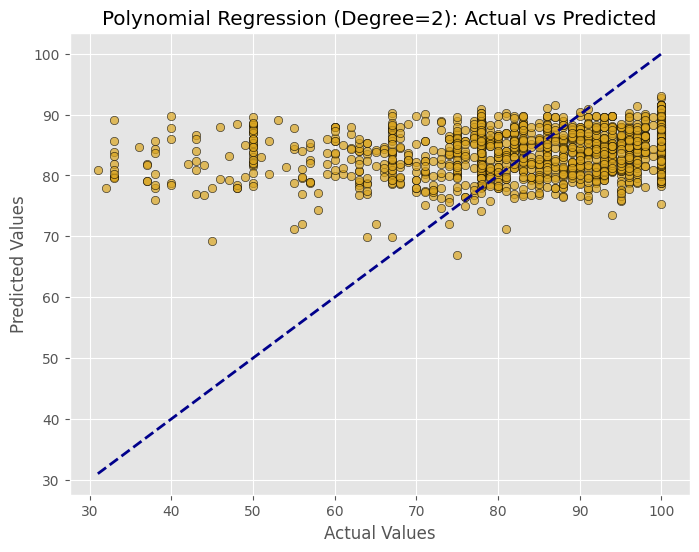

In [60]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
X_test_poly = poly.transform(X_test)
y_pred_poly = poly_model.predict(X_test_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
mae_poly = mean_squared_error(y_test, y_pred_poly)
r2 = r2_score(y_test, y_pred_poly)
print(f"Polynomial Regression MSE: {mse_poly}")
print(f"Polynomial Regression MAE: {mae_poly}")
print(f"R²: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_poly, color='goldenrod', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='darkblue', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Polynomial Regression (Degree=2): Actual vs Predicted')
plt.grid(True)
plt.show()

## Lasso Regression

Lasso MSE: 220.43272248805724
Lasso MAE: 11.927285694585928
R²: 0.0426101678902433


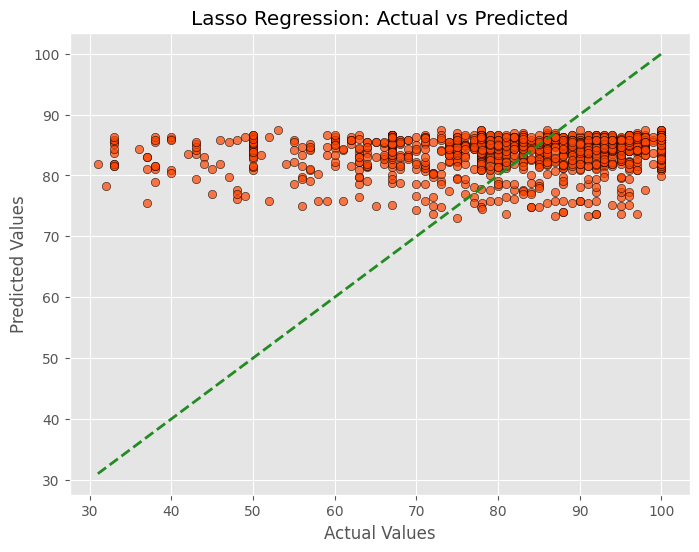

In [61]:
lasso_model = Lasso(random_state=42)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2 = r2_score(y_test, y_pred_lasso)
print(f"Lasso MSE: {mse_lasso}")
print(f"Lasso MAE: {mae_lasso}")
print(f"R²: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso, color='orangered', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='forestgreen', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Lasso Regression: Actual vs Predicted')
plt.grid(True)
plt.show()

## Ridge

Ridge MSE: 216.68909435350955
Ridge MAE: 11.761451680237863
R²: 0.05886960283602427


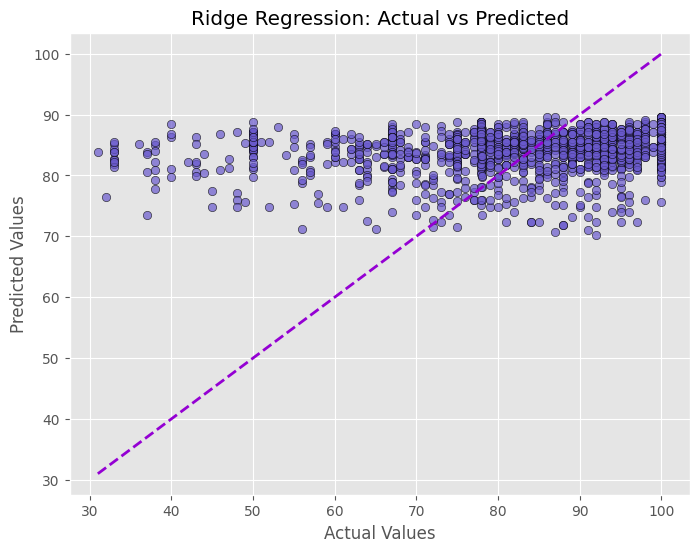

In [62]:
ridge_model = Ridge(random_state=42)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2 = r2_score(y_test, y_pred_ridge)
print(f"Ridge MSE: {mse_ridge}")
print(f"Ridge MAE: {mae_ridge}")
print(f"R²: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge, color='slateblue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='darkviolet', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Ridge Regression: Actual vs Predicted')
plt.grid(True)
plt.show()

## Decsion Trees

Decision Tree MSE: 370.21020709618574
Decision Tree MAE: 14.601316428426696
R²: -0.607907773476501


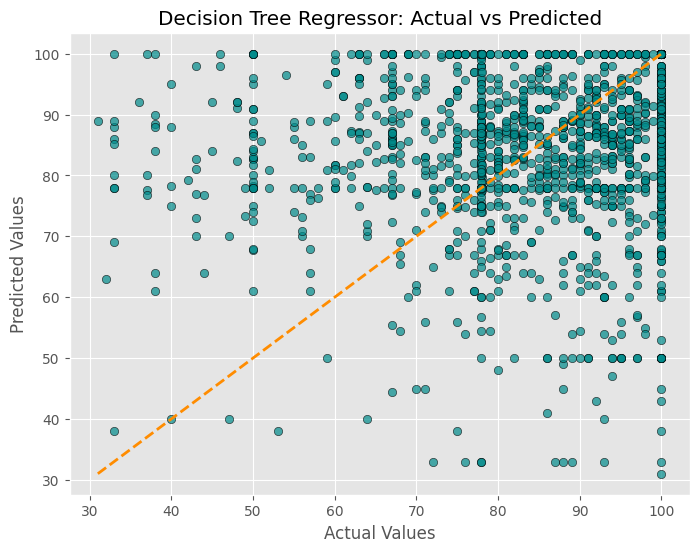

In [63]:
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)

r2_tree = r2_score(y_test, y_pred_tree)
print(f"Decision Tree MSE: {mse_tree}")
print(f"Decision Tree MAE: {mae_tree}")
print(f"R²: {r2_tree}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_tree, color='darkcyan', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='darkorange', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree Regressor: Actual vs Predicted')
plt.grid(True)
plt.show()

## Linear

Linear Regression MSE: 216.68803322637046
Linear Regression MAE: 11.761358628214047
Linear Regression R²: 0.05887421155437644


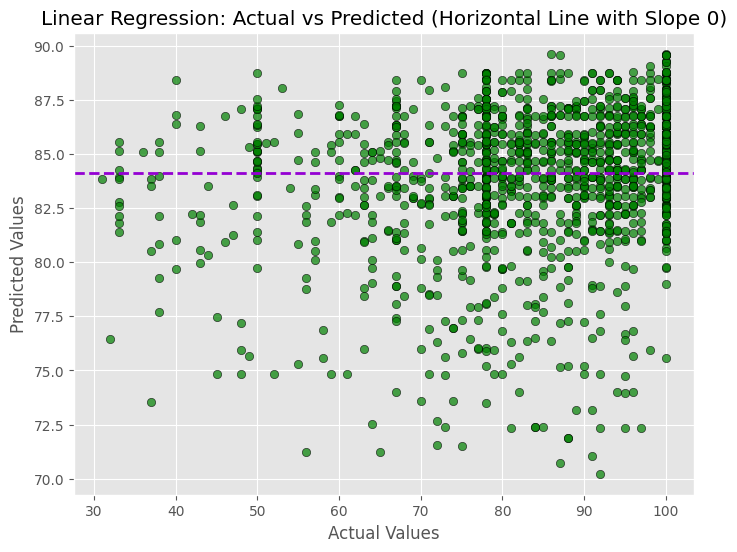

In [64]:
linear_model = LinearRegression(fit_intercept=True)  
linear_model.fit(X_train, y_train)

y_pred_linear = linear_model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression MSE: {mse_linear}")
print(f"Linear Regression MAE: {mae_linear}")
print(f"Linear Regression R²: {r2_linear}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linear, color='green', edgecolor='k', alpha=0.7)
plt.axhline(y=y_pred_linear.mean(), color='darkviolet', linestyle='--', linewidth=2)  
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted (Horizontal Line with Slope 0)')
plt.grid(True)
plt.show()

# Classification Ms2

In [65]:
Classification_df = MergeDatasets(demos,dlcs,gamalyticMS2,info,"Classification_combined_games")
Classification_df.head()
df = Classification_df
df['reviewScore']

Index(['name_x', 'name_y', 'price', 'copiesSold', 'publisherClass',
       'reviewScore', 'aiContent', 'name', 'metacritic', 'steam_achievements',
       'steam_trading_cards', 'workshop_support', 'genres',
       'achievements_total', 'release_date', 'supported_platforms'],
      dtype='object')
Demos: (15449, 4)
DLCs: (5445, 3)
Gamalytic: (93338, 6)
Merged shape: (9159, 16)


0              Positive
1              Positive
2              Positive
3       Mostly Positive
4              Positive
             ...       
9154           Positive
9155      Very Positive
9156      Very Positive
9157           Positive
9158           Positive
Name: reviewScore, Length: 9159, dtype: object

## Data Inspection

In [66]:
df.shape
df.info()
df.describe(include='all')  
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9159 entries, 0 to 9158
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name_x               9158 non-null   object 
 1   name_y               649 non-null    object 
 2   price                9159 non-null   float64
 3   copiesSold           9159 non-null   int64  
 4   publisherClass       9159 non-null   object 
 5   aiContent            0 non-null      float64
 6   name                 7535 non-null   object 
 7   metacritic           483 non-null    object 
 8   steam_achievements   7535 non-null   object 
 9   steam_trading_cards  7535 non-null   object 
 10  workshop_support     7535 non-null   object 
 11  genres               7531 non-null   object 
 12  achievements_total   4792 non-null   object 
 13  release_date         7535 non-null   object 
 14  supported_platforms  7535 non-null   object 
 15  reviewScore          9159 non-null   o

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,name_x,name_y,price,copiesSold,publisherClass,aiContent,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms,reviewScore
0,Rolando Deluxe Demo,NaN,9.99,58,Hobbyist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positive
1,Outrunner: Neon Nights Demo,NaN,9.99,60,Hobbyist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positive
2,Bubble Ghost Remake Demo,NaN,19.99,253,Indie,NaN,Bubble Ghost Remake,NaN,True,False,False,"Action, Adventure, Indie",NaN,"Mar 26, 2025",['windows'],Positive
3,Time Handlers Demo,NaN,13.99,174,Hobbyist,NaN,Time Handlers,NaN,True,False,False,"Adventure, Indie",32,"Jan 11, 2024","['windows', 'mac', 'linux']",Mostly Positive
4,Musical Vibes Demo,NaN,11.99,8,Hobbyist,NaN,Musical Vibes,NaN,False,False,False,Casual,NaN,"Nov 1, 2023",['windows'],Positive


In [67]:
df = Classification_df
print("Combined shape:", df.shape)
df.info()

Combined shape: (9159, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9159 entries, 0 to 9158
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name_x               9158 non-null   object 
 1   name_y               649 non-null    object 
 2   price                9159 non-null   float64
 3   copiesSold           9159 non-null   int64  
 4   publisherClass       9159 non-null   object 
 5   aiContent            0 non-null      float64
 6   name                 7535 non-null   object 
 7   metacritic           483 non-null    object 
 8   steam_achievements   7535 non-null   object 
 9   steam_trading_cards  7535 non-null   object 
 10  workshop_support     7535 non-null   object 
 11  genres               7531 non-null   object 
 12  achievements_total   4792 non-null   object 
 13  release_date         7535 non-null   object 
 14  supported_platforms  7535 non-null   object 
 15  reviewScore

In [68]:
df.describe()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,price,copiesSold,aiContent
count,9159.000000,9.159000e+03,0.0
mean,10.145054,4.625278e+04,NaN
std,9.803252,4.806317e+05,NaN
min,0.000000,0.000000e+00,NaN
25%,4.990000,4.600000e+01,NaN
50%,7.990000,3.740000e+02,NaN
75%,13.990000,3.583000e+03,NaN
max,240.000000,2.624442e+07,NaN


In [69]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,name_x,name_y,price,copiesSold,publisherClass,aiContent,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms,reviewScore
0,Rolando Deluxe Demo,NaN,9.99,58,Hobbyist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positive
1,Outrunner: Neon Nights Demo,NaN,9.99,60,Hobbyist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positive
2,Bubble Ghost Remake Demo,NaN,19.99,253,Indie,NaN,Bubble Ghost Remake,NaN,True,False,False,"Action, Adventure, Indie",NaN,"Mar 26, 2025",['windows'],Positive
3,Time Handlers Demo,NaN,13.99,174,Hobbyist,NaN,Time Handlers,NaN,True,False,False,"Adventure, Indie",32,"Jan 11, 2024","['windows', 'mac', 'linux']",Mostly Positive
4,Musical Vibes Demo,NaN,11.99,8,Hobbyist,NaN,Musical Vibes,NaN,False,False,False,Casual,NaN,"Nov 1, 2023",['windows'],Positive


In [70]:
df.tail()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,name_x,name_y,price,copiesSold,publisherClass,aiContent,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms,reviewScore
9154,Miryam: The Polluted Land DEMO,NaN,4.99,52,Hobbyist,NaN,Miryam: The Polluted Land,NaN,True,True,True,"Adventure, Casual, Indie, RPG, Strategy",NaN,"Mar 5, 2025","['windows', 'mac', 'linux']",Positive
9155,ORDER 13 Demo,NaN,8.99,30107,Indie,NaN,ORDER 13,NaN,False,False,False,"Action, Indie, Simulation",NaN,Mar-25,['windows'],Very Positive
9156,Fruitbus Demo,NaN,24.99,16344,Indie,NaN,Fruitbus,NaN,True,False,False,"Adventure, Casual, Indie, Simulation",30.0,"Oct 28, 2024",['windows'],Very Positive
9157,Drill to the Stars Demo,NaN,14.99,57,Hobbyist,NaN,Drill to the Stars,NaN,True,False,False,"Indie, Strategy",27.0,"Feb 7, 2025",['windows'],Positive
9158,Mechanic 8230: Escape from Ilgrot Demo,NaN,12.99,3150,Indie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positive


In [71]:
df.isna().sum()

name_x                    1
name_y                 8510
price                     0
copiesSold                0
publisherClass            0
aiContent              9159
name                   1624
metacritic             8676
steam_achievements     1624
steam_trading_cards    1624
workshop_support       1624
genres                 1628
achievements_total     4367
release_date           1624
supported_platforms    1624
reviewScore               0
dtype: int64

In [72]:
df.isnull().sum()

name_x                    1
name_y                 8510
price                     0
copiesSold                0
publisherClass            0
aiContent              9159
name                   1624
metacritic             8676
steam_achievements     1624
steam_trading_cards    1624
workshop_support       1624
genres                 1628
achievements_total     4367
release_date           1624
supported_platforms    1624
reviewScore               0
dtype: int64

In [73]:
df.duplicated().sum()
df['reviewScore'].isna().sum()

0

In [74]:
print("\n=== Detailed Column Analysis ===")

print("\n1. Metacritic Analysis:")
print("Missing values:", df['metacritic'].isna().sum())
print("Percentage missing:", (df['metacritic'].isna().sum() / len(df)) * 100)

    
print("\nMetacritic statistics:")
df['metacritic'].describe()

print("\n2. Achievements Analysis:")

df['achievements_total'] = pd.to_numeric(df['achievements_total'], errors='coerce')

print("Missing values:", df['achievements_total'].isna().sum())
print("Percentage missing:", (df['achievements_total'].isna().sum() / len(df)) * 100)

print("\nGames with achievements:")
print(df[df['achievements_total'] > 0]['achievements_total'].describe())

print("\n3. Genres Analysis:")
print("Missing values:", df['genres'].isna().sum())
print("Percentage missing:", (df['genres'].isna().sum() / len(df)) * 100)
print("\nTop 10 most common genres:")
print(df['genres'].value_counts().head(10))

print("\n4. Release Date Analysis:")
print("Missing values:", df['release_date'].isna().sum())
print("Percentage missing:", (df['release_date'].isna().sum() / len(df)) * 100)
print("\nRelease date distribution:")
print(df['release_date'].value_counts().head())

print("\n5. High Missing Value Columns Analysis:")
columns_to_check = ['aiContent','name_x', 'name_y']
for col in columns_to_check:
    print(f"\n{col} missing values:", df[col].isna().sum())
    print(f"Percentage missing:", (df[col].isna().sum() / len(df)) * 100)

print("\n6. Duplicate Analysis:")
print("Number of duplicate rows:", df.duplicated().sum())
print("\nSample of duplicate rows:")
df[df.duplicated()].head()


=== Detailed Column Analysis ===

1. Metacritic Analysis:
Missing values: 8676
Percentage missing: 94.72649852603996

Metacritic statistics:

2. Achievements Analysis:
Missing values: 4367
Percentage missing: 47.67987771590785

Games with achievements:
count    4713.000000
mean       30.237853
std        46.333891
min         1.000000
25%        13.000000
50%        23.000000
75%        38.000000
max      2600.000000
Name: achievements_total, dtype: float64

3. Genres Analysis:
Missing values: 1628
Percentage missing: 17.77486625177421

Top 10 most common genres:
genres
Action, Indie               480
Action, Adventure, Indie    441
Adventure, Indie            371
Casual, Indie               322
Adventure, Indie, RPG       254
Adventure, Casual, Indie    248
Action, Casual, Indie       225
Action                      197
Indie                       191
Casual, Indie, Strategy     155
Name: count, dtype: int64

4. Release Date Analysis:
Missing values: 1624
Percentage missing: 17.73119

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,name_x,name_y,price,copiesSold,publisherClass,aiContent,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms,reviewScore


In [75]:
df['reviewScore']

0              Positive
1              Positive
2              Positive
3       Mostly Positive
4              Positive
             ...       
9154           Positive
9155      Very Positive
9156      Very Positive
9157           Positive
9158           Positive
Name: reviewScore, Length: 9159, dtype: object

## Preprocessing

### Data Cleaning

#### Outliers

In [76]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    df.loc[outliers, col] = df[col].mean()
df.head()

/tmp/ipykernel_14/3648659883.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '46252.78021618081' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers, col] = df[col].mean()
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/loca

,name_x,name_y,price,copiesSold,publisherClass,aiContent,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms,reviewScore
0,Rolando Deluxe Demo,NaN,9.99,58.0,Hobbyist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positive
1,Outrunner: Neon Nights Demo,NaN,9.99,60.0,Hobbyist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positive
2,Bubble Ghost Remake Demo,NaN,19.99,253.0,Indie,NaN,Bubble Ghost Remake,NaN,True,False,False,"Action, Adventure, Indie",NaN,"Mar 26, 2025",['windows'],Positive
3,Time Handlers Demo,NaN,13.99,174.0,Hobbyist,NaN,Time Handlers,NaN,True,False,False,"Adventure, Indie",32.0,"Jan 11, 2024","['windows', 'mac', 'linux']",Mostly Positive
4,Musical Vibes Demo,NaN,11.99,8.0,Hobbyist,NaN,Musical Vibes,NaN,False,False,False,Casual,NaN,"Nov 1, 2023",['windows'],Positive


#### Name

In [77]:
df['achievements_total'] = df['achievements_total'].fillna(0)
df['genres'] = df['genres'].fillna(df['genres'].mode()[0])
print(df.columns)
df = df.dropna(subset=['release_date'])
columns_to_drop = ['metacritic']
df = df.drop(columns=columns_to_drop)
df = df.drop_duplicates()
print("Shape after Previous preprocessing:", df.shape)
print("\nMissing values after preprocessing:")
print(df.isna().sum())

Index(['name_x', 'name_y', 'price', 'copiesSold', 'publisherClass',
       'aiContent', 'name', 'metacritic', 'steam_achievements',
       'steam_trading_cards', 'workshop_support', 'genres',
       'achievements_total', 'release_date', 'supported_platforms',
       'reviewScore'],
      dtype='object')
Shape after Previous preprocessing: (7535, 15)

Missing values after preprocessing:
name_x                    1
name_y                 7015
price                     0
copiesSold                0
publisherClass            0
aiContent              7535
name                      0
steam_achievements        0
steam_trading_cards       0
workshop_support          0
genres                    0
achievements_total        0
release_date              0
supported_platforms       0
reviewScore               0
dtype: int64


In [78]:
df['name'] = df['name'].fillna('Unknown Game') 
df['name'] = df['name'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
df['name'] = df['name'].str.lower()
df['name'] = df['name'].str.strip()
df['name_tokens'] = df['name'].str.split()
df['name_length'] = df['name'].apply(len)
df[['name', 'name_tokens', 'name_length']].head()

,name,name_tokens,name_length
2,bubble ghost remake,"[bubble, ghost, remake]",19
3,time handlers,"[time, handlers]",13
4,musical vibes,"[musical, vibes]",13
6,nudel tag,"[nudel, tag]",9
8,throne of bone,"[throne, of, bone]",14


#### Date

Missing values in 'year': 0
Missing values in 'day': 0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


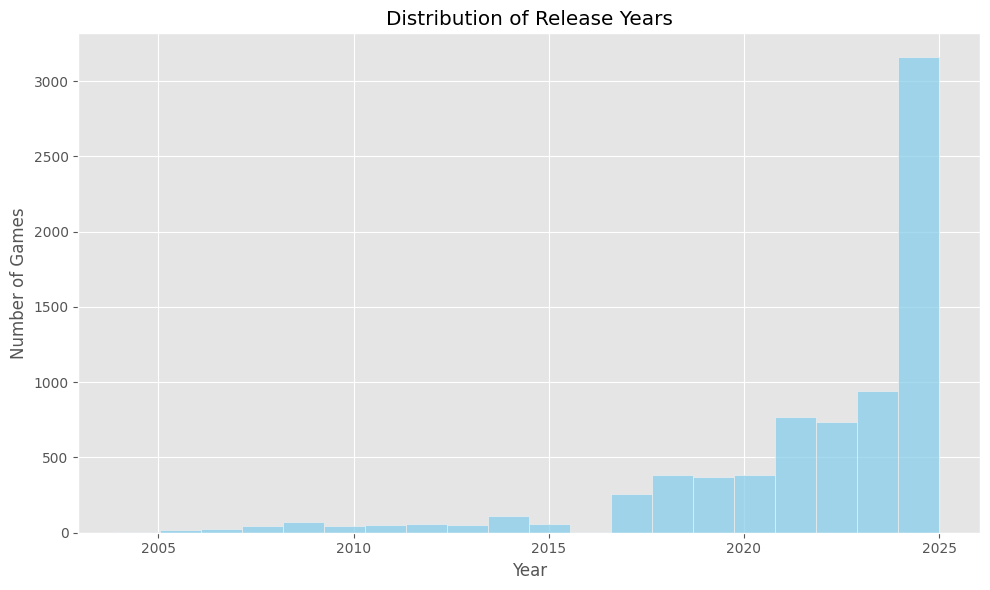

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


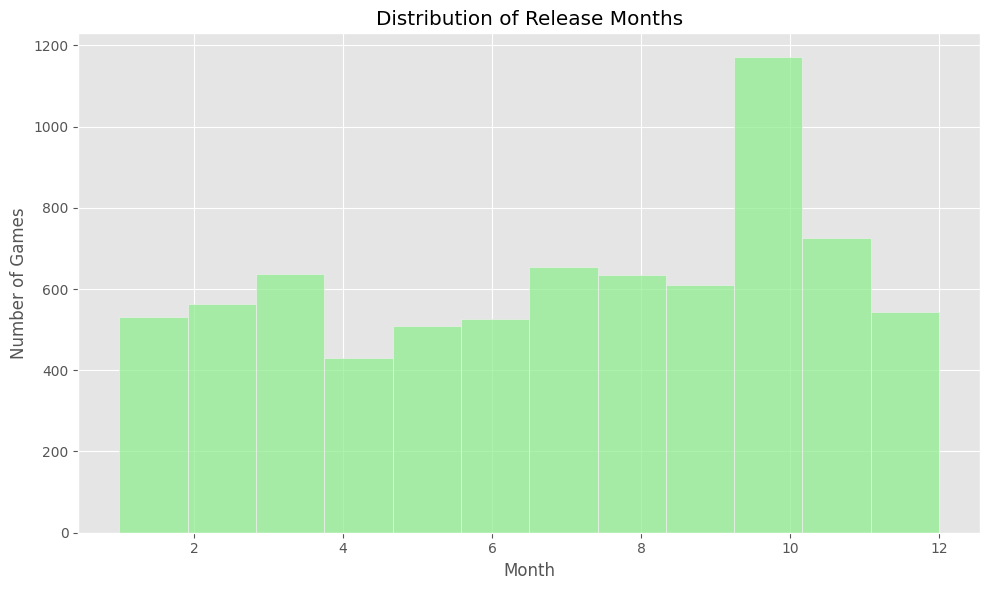

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


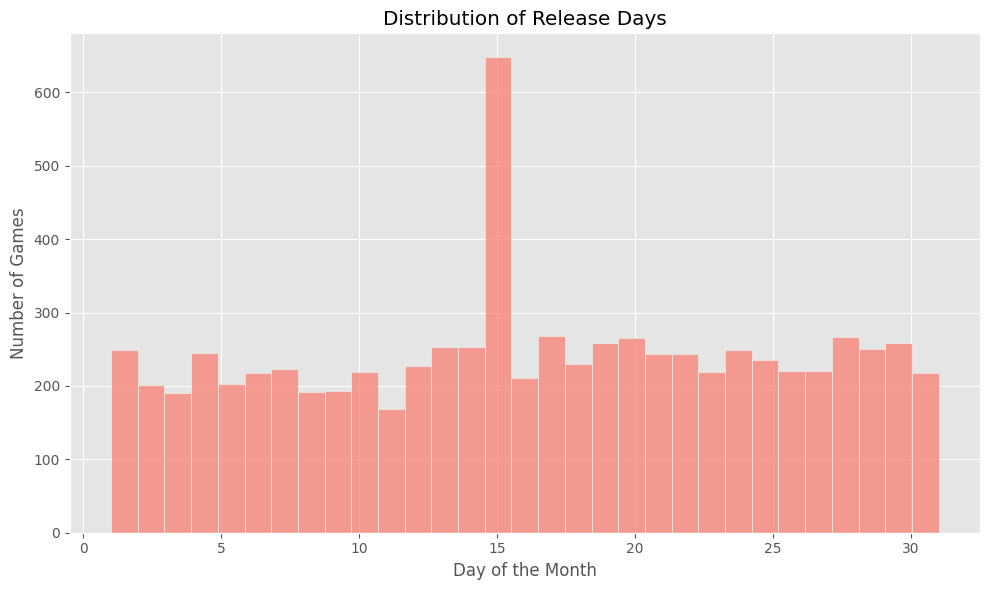

In [79]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

df['year'] = df['release_date'].dt.year  
df['month'] = df['release_date'].dt.month  
df['day'] = df['release_date'].dt.day 

df['year'] = df['year'].fillna(df['year'].mode()[0])
df['day'] = df['day'].fillna(df['day'].mode()[0])
df['month'] = df['month'].fillna(df['month'].mode()[0])


print(f"Missing values in 'year': {df['year'].isnull().sum()}")
print(f"Missing values in 'day': {df['day'].isnull().sum()}")


df = df.drop('release_date', axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(df['year'], kde=False, bins=20, color='skyblue')
plt.title('Distribution of Release Years')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['month'], kde=False, bins=12, color='lightgreen')
plt.title('Distribution of Release Months')
plt.xlabel('Month')
plt.ylabel('Number of Games')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['day'], kde=False, bins=31, color='salmon')
plt.title('Distribution of Release Days')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Games')
plt.grid(True)
plt.tight_layout()
plt.show()

### Encoding

#### Boolean Features

In [80]:
 bool_features = ['steam_achievements', 'steam_trading_cards', 'workshop_support']
for feature in bool_features:
    df[feature] = df[feature].astype(int)

#### Target Class Encoding

In [81]:
le = LabelEncoder()
df['reviewScore'] = le.fit_transform(df['reviewScore'])

#### Publisher Class

In [82]:
label_encoder = LabelEncoder()
df['publisher_class_encoded'] = label_encoder.fit_transform(df['publisherClass'])
df[['publisherClass', 'publisher_class_encoded']].head()
df.drop(columns='publisherClass',inplace=True)
print(df.columns)

Index(['name_x', 'name_y', 'price', 'copiesSold', 'aiContent', 'name',
       'steam_achievements', 'steam_trading_cards', 'workshop_support',
       'genres', 'achievements_total', 'supported_platforms', 'reviewScore',
       'name_tokens', 'name_length', 'year', 'month', 'day',
       'publisher_class_encoded'],
      dtype='object')


#### Genres

In [83]:
genres = df['genres'].str.split(',', expand=True)
genre_columns = []

unique_genres = pd.unique(genres.values.ravel())

for genre in unique_genres:
    df[genre] = genres.apply(lambda row: 1 if genre in row.values else 0, axis=1)
    genre_columns.append(genre)

df = df.drop('genres', axis=1)

df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,name_x,name_y,price,copiesSold,aiContent,name,steam_achievements,steam_trading_cards,workshop_support,achievements_total,...,Software Training,Utilities,Game Development,Violent,Action,Gore,Sexual Content,Violent,Gore,Audio Production
2,Bubble Ghost Remake Demo,NaN,19.99,253.0,NaN,bubble ghost remake,1,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Time Handlers Demo,NaN,13.99,174.0,NaN,time handlers,1,0,0,32.0,...,0,0,0,0,0,0,0,0,0,0
4,Musical Vibes Demo,NaN,11.99,8.0,NaN,musical vibes,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,Nudel Tag Demo,NaN,6.49,1.0,NaN,nudel tag,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
8,Throne of Bone Demo,NaN,16.99,8167.0,NaN,throne of bone,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### Supported Platforms

In [84]:
platforms = df['supported_platforms'].str.split(',', expand=True)

df['windows'] = platforms[0].apply(lambda x: 1 if pd.notna(x) and 'windows' in x.lower() else 0)
df['linux'] = platforms[1].apply(lambda x: 1 if pd.notna(x) and 'linux' in x.lower() else 0)
df['mac'] = platforms[2].apply(lambda x: 1 if pd.notna(x) and 'mac' in x.lower() else 0)

df = df.drop('supported_platforms', axis=1)


df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,name_x,name_y,price,copiesSold,aiContent,name,steam_achievements,steam_trading_cards,workshop_support,achievements_total,...,Violent,Action,Gore,Sexual Content,Violent,Gore,Audio Production,windows,linux,mac
2,Bubble Ghost Remake Demo,NaN,19.99,253.0,NaN,bubble ghost remake,1,0,0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,Time Handlers Demo,NaN,13.99,174.0,NaN,time handlers,1,0,0,32.0,...,0,0,0,0,0,0,0,1,0,0
4,Musical Vibes Demo,NaN,11.99,8.0,NaN,musical vibes,0,0,0,0.0,...,0,0,0,0,0,0,0,1,0,0
6,Nudel Tag Demo,NaN,6.49,1.0,NaN,nudel tag,0,0,0,0.0,...,0,0,0,0,0,0,0,1,0,0
8,Throne of Bone Demo,NaN,16.99,8167.0,NaN,throne of bone,0,0,0,0.0,...,0,0,0,0,0,0,0,1,0,0


## Feature Engineering and Selection

### Total genres Feature

In [85]:
df['Total_Genres'] = df[genre_columns].sum(axis=1)
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,name_x,name_y,price,copiesSold,aiContent,name,steam_achievements,steam_trading_cards,workshop_support,achievements_total,...,Action,Gore,Sexual Content,Violent,Gore,Audio Production,windows,linux,mac,Total_Genres
2,Bubble Ghost Remake Demo,NaN,19.99,253.0,NaN,bubble ghost remake,1,0,0,0.0,...,0,0,0,0,0,0,1,0,0,4
3,Time Handlers Demo,NaN,13.99,174.0,NaN,time handlers,1,0,0,32.0,...,0,0,0,0,0,0,1,0,0,3
4,Musical Vibes Demo,NaN,11.99,8.0,NaN,musical vibes,0,0,0,0.0,...,0,0,0,0,0,0,1,0,0,2
6,Nudel Tag Demo,NaN,6.49,1.0,NaN,nudel tag,0,0,0,0.0,...,0,0,0,0,0,0,1,0,0,3
8,Throne of Bone Demo,NaN,16.99,8167.0,NaN,throne of bone,0,0,0,0.0,...,0,0,0,0,0,0,1,0,0,3


In [86]:
zero_genres = (df['Total_Genres']==0).sum()
print(zero_genres)

0


### Number of Platforms Feature

In [87]:
platforms_columns = ['windows','linux','mac']
df['Total_Platforms'] = df[platforms_columns].sum(axis=1)

In [88]:
zero_platforms = (df['Total_Platforms']== 0 ).sum()
print(zero_platforms)
df = df[df['Total_Platforms']!=0]
zero_platforms_after = (df['Total_Platforms']== 0 ).sum()
print(zero_platforms_after)

1
0


In [89]:
print(df.columns)

Index([                 'name_x',                  'name_y',
                         'price',              'copiesSold',
                     'aiContent',                    'name',
            'steam_achievements',     'steam_trading_cards',
              'workshop_support',      'achievements_total',
                   'reviewScore',             'name_tokens',
                   'name_length',                    'year',
                         'month',                     'day',
       'publisher_class_encoded',                  'Action',
                    ' Adventure',                  ' Indie',
                            None,               'Adventure',
                        'Casual',                 ' Casual',
                      'Strategy',           ' Early Access',
                          ' RPG',                   'Indie',
                       ' Racing',                 ' Sports',
                     ' Strategy',             ' Simulation',
                        

In [90]:
print(platforms_columns)

['windows', 'linux', 'mac']


In [91]:
genre_columns = list(set(
    col.strip() for col in genre_columns if isinstance(col, str)
))
print(genre_columns)

['Indie', 'Racing', 'Early Access', 'Sports', 'Strategy', 'Adventure', 'Education', 'Audio Production', 'Violent', 'Free To Play', 'Casual', 'Gore', 'RPG', 'Game Development', 'Utilities', 'Massively Multiplayer', 'Simulation', 'Software Training', 'Action', 'Sexual Content']


In [92]:
df_scaled.describe()

,price,copiesSold,steam_achievements,steam_trading_cards,Action,Adventure,Indie,None,Adventure,Casual,...,Utilities,Game Development,Violent,Action,Gore,Sexual Content,Violent,Gore,Audio Production,reviewScore
count,7.535000e+03,7.535000e+03,7.535000e+03,7.535000e+03,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,...,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000,7535.000000
mean,-6.412330e-17,-4.903546e-17,1.885979e-17,-3.017567e-17,0.432515,0.203185,0.653749,0.999867,0.228799,0.159788,...,0.000531,0.000133,0.001327,0.001062,0.000265,0.000398,0.000398,0.000929,0.000133,84.236670
std,1.000066e+00,1.000066e+00,1.000066e+00,1.000066e+00,0.495458,0.402396,0.475806,0.011520,0.420087,0.366433,...,0.023036,0.011520,0.036408,0.032569,0.016291,0.019951,0.019951,0.030467,0.011520,15.361992
min,-1.510790e+00,-5.178749e-01,-1.298566e+00,-4.525803e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000
25%,-6.727547e-01,-5.152207e-01,-1.298566e+00,-4.525803e-01,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,77.937875
50%,-1.689259e-01,-4.960644e-01,7.700800e-01,-4.525803e-01,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.000000
75%,5.028458e-01,-3.048189e-01,7.700800e-01,-4.525803e-01,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.000000
max,2.854047e+00,2.150895e+00,7.700800e-01,2.209553e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [93]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,name_x,name_y,price,copiesSold,aiContent,name,steam_achievements,steam_trading_cards,workshop_support,achievements_total,...,Gore,Sexual Content,Violent,Gore,Audio Production,windows,linux,mac,Total_Genres,Total_Platforms
2,Bubble Ghost Remake Demo,NaN,19.99,253.0,NaN,bubble ghost remake,1,0,0,0.0,...,0,0,0,0,0,1,0,0,4,1
3,Time Handlers Demo,NaN,13.99,174.0,NaN,time handlers,1,0,0,32.0,...,0,0,0,0,0,1,0,0,3,1
4,Musical Vibes Demo,NaN,11.99,8.0,NaN,musical vibes,0,0,0,0.0,...,0,0,0,0,0,1,0,0,2,1
6,Nudel Tag Demo,NaN,6.49,1.0,NaN,nudel tag,0,0,0,0.0,...,0,0,0,0,0,1,0,0,3,1
8,Throne of Bone Demo,NaN,16.99,8167.0,NaN,throne of bone,0,0,0,0.0,...,0,0,0,0,0,1,0,0,3,1


### Columns With Too much nulls

In [94]:
df.drop(columns=['name_x','name_y','aiContent'],inplace=True)
print(df.columns)

Index([                  'price',              'copiesSold',
                          'name',      'steam_achievements',
           'steam_trading_cards',        'workshop_support',
            'achievements_total',             'reviewScore',
                   'name_tokens',             'name_length',
                          'year',                   'month',
                           'day', 'publisher_class_encoded',
                        'Action',              ' Adventure',
                        ' Indie',                      None,
                     'Adventure',                  'Casual',
                       ' Casual',                'Strategy',
                 ' Early Access',                    ' RPG',
                         'Indie',                 ' Racing',
                       ' Sports',               ' Strategy',
                   ' Simulation',                  'Sports',
        ' Massively Multiplayer',            'Early Access',
                        

### Useless features

In [95]:
df.drop(columns=['name','name_tokens','name_length','mac','linux','windows'],inplace=True)
print(df.columns)

Index([                  'price',              'copiesSold',
            'steam_achievements',     'steam_trading_cards',
              'workshop_support',      'achievements_total',
                   'reviewScore',                    'year',
                         'month',                     'day',
       'publisher_class_encoded',                  'Action',
                    ' Adventure',                  ' Indie',
                            None,               'Adventure',
                        'Casual',                 ' Casual',
                      'Strategy',           ' Early Access',
                          ' RPG',                   'Indie',
                       ' Racing',                 ' Sports',
                     ' Strategy',             ' Simulation',
                        'Sports',  ' Massively Multiplayer',
                  'Early Access',                     'RPG',
                    'Simulation',            'Free To Play',
         'Massively Mult

#### Scaling

In [96]:
scale_cols = ['copiesSold', 'price', 'year', 'achievements_total']
scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])
df[scale_cols].head()

,copiesSold,price,year,achievements_total
2,-0.503321,1.846525,0.964218,-0.910081
3,-0.507879,0.838866,0.685472,0.925980
4,-0.517457,0.502980,0.406725,-0.910081
6,-0.517861,-0.420707,0.406725,-0.910081
8,-0.046708,1.342695,0.685472,-0.910081


In [97]:
df.to_csv('scaleD.csv', index=False)

In [98]:
review = df.pop('reviewScore')
df['reviewScore'] = review
df.head()

,price,copiesSold,steam_achievements,steam_trading_cards,workshop_support,achievements_total,year,month,day,publisher_class_encoded,...,Violent,Action,Gore,Sexual Content,Violent,Gore,Audio Production,Total_Genres,Total_Platforms,reviewScore
2,1.846525,-0.503321,1,0,0,-0.910081,0.964218,3.0,26.0,3,...,0,0,0,0,0,0,0,4,1,6
3,0.838866,-0.507879,1,0,0,0.925980,0.685472,1.0,11.0,2,...,0,0,0,0,0,0,0,3,1,2
4,0.502980,-0.517457,0,0,0,-0.910081,0.406725,11.0,1.0,2,...,0,0,0,0,0,0,0,2,1,6
6,-0.420707,-0.517861,0,0,0,-0.910081,0.406725,12.0,17.0,2,...,0,0,0,0,0,0,0,3,1,6
8,1.342695,-0.046708,0,0,0,-0.910081,0.685472,4.0,8.0,3,...,0,0,0,0,0,0,0,3,1,8


### Feature Selection

In [99]:
X = df.drop(columns=['reviewScore'])
X.columns = X.columns.astype(str)

y = df['reviewScore']

#Chi-Squared requires non-negative values
# χ^2=∑ E(O−E)^2/E

# Where:

# O = Observed frequency

# E = Expected frequency 

X_chi = X.copy()
X_chi = X_chi - X_chi.min()

selector_chi = SelectKBest(score_func=chi2, k=3)
selector_chi.fit(X_chi, y)
top_chi_features = X.columns[selector_chi.get_support()]

# Mutual Information
# I(X; Y) = Σx Σy P(x, y) * log( P(x, y) / (P(x) * P(y)) )
# where P(x, y) is the joint probability of feature X and target Y,
# and P(x), P(y) are the marginal probabilities.
selector_mi = SelectKBest(score_func=mutual_info_classif, k=3)
selector_mi.fit(X, y)
top_mi_features = X.columns[selector_mi.get_support()]

# Kendall's Tau
# τ = (Number of concordant pairs - Number of discordant pairs) / (n * (n - 1) / 2)
# Where:
# - Concordant pairs: pairs where the ranks of both elements agree in order.
# - Discordant pairs: pairs where the ranks disagree.
# - n is the number of pairs.
kendall_scores = []
for col in X.columns:
    tau, _ = kendalltau(X[col], y)
    kendall_scores.append(tau)
kendall_series = pd.Series(kendall_scores, index=X.columns)
top_kendall_features = kendall_series.abs().sort_values(ascending=False).head(3).index

print("Top 3 Chi-Squared features:", list(top_chi_features))
print("Top 3 Mutual Information features:", list(top_mi_features))
print("Top 3 Kendall's Tau features:", list(top_kendall_features))

Top 3 Chi-Squared features: ['price', 'copiesSold', 'achievements_total']
Top 3 Mutual Information features: ['copiesSold', 'year', 'publisher_class_encoded']
Top 3 Kendall's Tau features: ['copiesSold', 'achievements_total', 'steam_achievements']


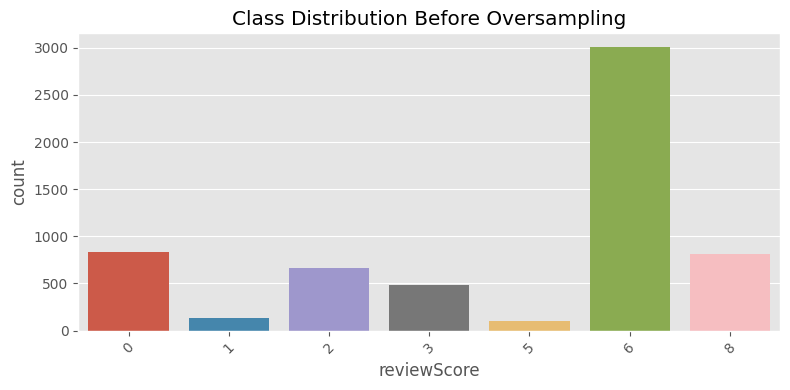

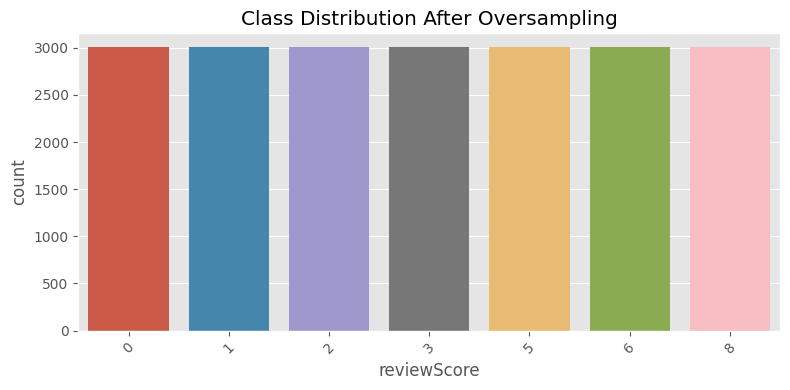

In [100]:
from imblearn.over_sampling import RandomOverSampler

# Select features and target
final_features = ['copiesSold', 'achievements_total', 'year']
X = df[final_features]
y = df['reviewScore']

# Remove classes with only 1 sample
class_counts = y.value_counts()
valid_classes = class_counts[class_counts > 1].index
df_filtered = df[df['reviewScore'].isin(valid_classes)]

# Update features and target after filtering
X = df_filtered[final_features]
y = df_filtered['reviewScore']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Plot class distribution before oversampling
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train)
plt.title("Class Distribution Before Oversampling")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Random oversampling (instead of SMOTE)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Plot class distribution after oversampling
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After Oversampling")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Classification Models

## Random Forest

In [101]:
print("Random Forest \n")
rf_model = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200],         
    'max_depth': [None, 10, 20, 30],        
    'min_samples_split': [2],              
    'min_samples_leaf': [1],               
    'max_features': ['sqrt', 'log2']       
}

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,         
    cv=5,                  
    n_jobs=-1,             
    verbose=2,
    random_state=42,
    scoring='accuracy'
)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)
best_rf = random_search.best_estimator_


y_train_pred = best_rf.predict(X_train)
y_pred = best_rf.predict(X_test)


train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = 1 - train_accuracy
test_accuracy = accuracy_score(y_test, y_pred)  
test_error = 1 - test_accuracy   

print("\nTrain Accuracy:", train_accuracy)
print("Train Error:", train_error)
print("\nTest Accuracy:", test_accuracy)
print("Test Error:", test_error)
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred, digits=3, zero_division=0))

Random Forest 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}

Train Accuracy: 0.7052282157676348
Train Error: 0.29477178423236516

Test Accuracy: 0.6562707365627074
Test Error: 0.3437292634372926

Classification Report (Test Data):
               precision    recall  f1-score   support

           0      0.382     0.062     0.107       209
           1      0.000     0.000     0.000        33
           2      0.000     0.000     0.000       166
           3      0.639     0.650     0.645       120
           5      0.000     0.000     0.000        25
           6      0.696     0.935     0.798       751
           8      0.578     0.966     0.723       203

    accuracy                          0.656      1507
   macro avg      0.328     0.373     0.325      1507
weighted avg      0.529     0.656     0.561      1507



## Decision Trees

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'gini', 'ccp_alpha': 0.01}
Train Accuracy: 0.6625726141078838
Test Accuracy: 0.6575978765759788

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       209
           1       0.00      0.00      0.00        33
           2       0.00      0.00      0.00       166
           3       0.59      0.70      0.64       120
           5       0.00      0.00      0.00        25
           6       0.69      0.94      0.80       751
           8       0.58      1.00      0.73       203

    accuracy                           0.66      1507
   macro avg       0.27      0.38      0.31      1507
weighted avg       0.47      0.66      0.55      1507



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


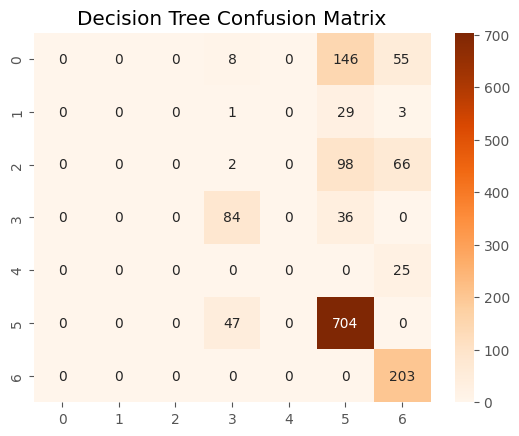

In [102]:
dt_model = DecisionTreeClassifier(random_state=42)


param_dist_dt = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1]
}


random_search_dt = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_dist_dt,
    n_iter=5, 
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    scoring='accuracy'
)


random_search_dt.fit(X_train, y_train)


print("Best Hyperparameters:", random_search_dt.best_params_)

best_dt = random_search_dt.best_estimator_


y_train_pred_dt = best_dt.predict(X_train)
y_pred_dt = best_dt.predict(X_test)


train_acc_dt = accuracy_score(y_train, y_train_pred_dt)
test_acc_dt = accuracy_score(y_test, y_pred_dt)

print(f"Train Accuracy: {train_acc_dt}")
print(f"Test Accuracy: {test_acc_dt}")
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred_dt))


sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Oranges')
plt.title('Decision Tree Confusion Matrix')
plt.show()

## Gradient Boosting

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.01}
Train Accuracy: 0.6599170124481328
Train Error: 0.34008298755186717
Test Accuracy: 0.6575978765759788
Test Error: 0.3424021234240212

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.25      0.00      0.01       209
           1       0.00      0.00      0.00        33
           2       0.00      0.00      0.00       166
           3       0.67      0.52      0.58       120
           5       0.00      0.00      0.00        25
           6       0.68      0.97      0.80       751
           8       0.58      1.00      0.74       203

    accuracy                           0.66      1507
   macro avg       0.31      0.36      0.30      1507
weighted avg       0.51      0.66      0.55      1507



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


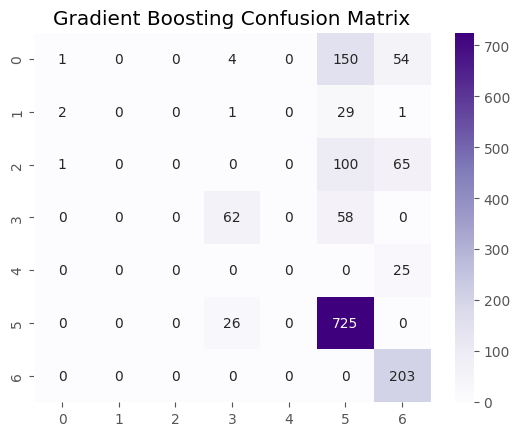

In [103]:
gb_model = GradientBoostingClassifier(random_state=42)


param_dist_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0]
}


random_search_gb = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_dist_gb,
    n_iter=5, 
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    scoring='accuracy'
)

random_search_gb.fit(X_train, y_train)


print("Best Hyperparameters:", random_search_gb.best_params_)

best_gb = random_search_gb.best_estimator_


y_train_pred_gb = best_gb.predict(X_train)
y_pred_gb = best_gb.predict(X_test)

train_accuracy_gb = accuracy_score(y_train, y_train_pred_gb)
train_error_gb = 1 - train_accuracy_gb
print("Train Accuracy:", train_accuracy_gb)
print("Train Error:", train_error_gb)


test_accuracy_gb = accuracy_score(y_test, y_pred_gb)
test_error_gb = 1 - test_accuracy_gb
print("Test Accuracy:", test_accuracy_gb)
print("Test Error:", test_error_gb)


print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred_gb))
sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt='d', cmap='Purples')
plt.title('Gradient Boosting Confusion Matrix')
plt.show()

## Logistic Rgeression

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The

Best Hyperparameters: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 1, 'C': 10}
Train Accuracy: 0.6120
Train Error: 0.3880
Test Accuracy: 0.6151
Test Error: 0.3849

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.30      0.10      0.15       209
           1       0.00      0.00      0.00        33
           2       0.00      0.00      0.00       166
           3       0.00      0.00      0.00       120
           5       0.00      0.00      0.00        25
           6       0.64      0.98      0.78       751
           8       0.59      0.83      0.69       203

    accuracy                           0.62      1507
   macro avg       0.22      0.27      0.23      1507
weighted avg       0.44      0.62      0.50      1507



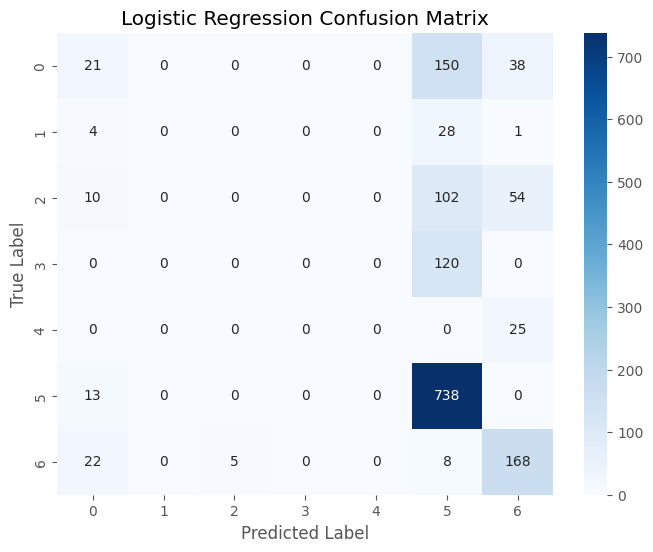

In [104]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

param_dist_logreg = {
    'C': [0.01, 0.1, 1, 10],                  
    'penalty': ['l1', 'l2', 'elasticnet'],   
    'solver': ['saga'],                      
    'l1_ratio': [0, 0.5, 1]                 
}


random_search_logreg = RandomizedSearchCV(
    estimator=logreg_model,
    param_distributions=param_dist_logreg,
    n_iter=5,             
    cv=5,                  
    n_jobs=-1,             
    verbose=2,
    random_state=42,
    scoring='accuracy'
)


random_search_logreg.fit(X_train, y_train)

print("Best Hyperparameters:", random_search_logreg.best_params_)

best_logreg = random_search_logreg.best_estimator_

y_train_pred_logreg = best_logreg.predict(X_train)
y_pred_logreg = best_logreg.predict(X_test)


train_accuracy_logreg = accuracy_score(y_train, y_train_pred_logreg)
train_error_logreg = 1 - train_accuracy_logreg
print(f"Train Accuracy: {train_accuracy_logreg:.4f}")
print(f"Train Error: {train_error_logreg:.4f}")

test_accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
test_error_logreg = 1 - test_accuracy_logreg
print(f"Test Accuracy: {test_accuracy_logreg:.4f}")
print(f"Test Error: {test_error_logreg:.4f}")

print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred_logreg, zero_division=0))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_logreg), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## SVM

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': 100}
Train Accuracy: 0.6360165975103734
Test Accuracy: 0.6270736562707365

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.33      0.02      0.04       209
           1       0.00      0.00      0.00        33
           2       0.00      0.00      0.00       166
           3       0.00      0.00      0.00       120
           5       0.00      0.00      0.00        25
           6       0.65      0.99      0.79       751
           8       0.58      0.95      0.72       203

    accuracy                           0.63      1507
   macro avg       0.22      0.28      0.22      1507
weighted avg       0.45      0.63      0.49      1507



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


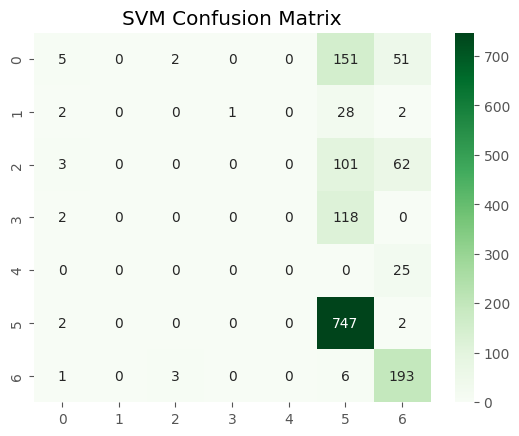

In [105]:
svm_model = SVC(random_state=42)
param_dist_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
random_search_svm = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_dist_svm,
    n_iter=2,
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    scoring='accuracy'
)
random_search_svm.fit(X_train, y_train)
print("Best Hyperparameters:", random_search_svm.best_params_)

best_svm = random_search_svm.best_estimator_

y_train_pred_svm = best_svm.predict(X_train)
y_pred_svm = best_svm.predict(X_test)


train_acc_svm = accuracy_score(y_train, y_train_pred_svm)
test_acc_svm = accuracy_score(y_test, y_pred_svm)

print(f"Train Accuracy: {train_acc_svm}")
print(f"Test Accuracy: {test_acc_svm}")

print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred_svm))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Greens')
plt.title('SVM Confusion Matrix')
plt.show()